# Import libraries

In [664]:
import scipy as sc
from scipy.integrate import odeint, solve_bvp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pyccl as ccl
from mpl_toolkits import mplot3d
import seaborn as sns
import pandas as pd
#from sklearn.decomposition import PCA
import corner
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, Math
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [995]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
col = sns.color_palette("colorblind") 

# Function to scale -ve and positive axis differently
def get_scale(a=1):  # a is the scale of your negative axis
    def forward(x):
        x = (x >= 0) * x + (x < 0) * x * a
        return x

    def inverse(x):
        x = (x >= 0) * x + (x < 0) * x / a
        return x

    return forward, inverse

## Useful info

In [3]:
""" matter_power_spectrum_types = {
    'halo_model':   lib.halo_model,
    'halofit':      lib.halofit,
    'linear':       lib.linear,
    'emu':          lib.emu
}
"""

" matter_power_spectrum_types = {\n    'halo_model':   lib.halo_model,\n    'halofit':      lib.halofit,\n    'linear':       lib.linear,\n    'emu':          lib.emu\n}\n"

# Add real data

In [5]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find Delta(a) and sigma8

## Define useful functions for growth


In [803]:
# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_g = Omega_r - alpha_C
    if alpha_C == 0:
        return (k**2)*a**2/((k**2 + 3*(Easquared(a,cosmo1)/a)**2)*a**2)
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_g - Omega_k - alpha_C
        return (k**2)*a**2/((k**2 + 3*(Easquared(a,cosmo1)/a)**2)*a**2 - 6*alpha_C)


# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_g = Omega_r - alpha_C
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_g - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_g + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# FUNCTIONS FOR BVP

# Second order ODE for D_+(a)
def solverGrowth(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)))

# BC for our ODE. D(a=0) = 0, D(a = 1) = 1
# can set value of either function (y[0] or y[1]) at the lower (a) or upper (b) limit
def bc(ya, yb):
    return np.array([ya[0], yb[0] - 1])

# Function that returns D, f for a given cosmo, a and k
#can only solve up to a = np.sqrt(6*cosmo1[-1]/k[i]**2)
def solve_for_growth(a, cosmo1, k):
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for j in range(len(k)):
        if 0 < 6*cosmo1[-1]/(k[j]**2 + 3*(Easquared(np.min(a),cosmo1)/np.min(a))**2) < 1:
            if np.sqrt(6*cosmo1[-1]/(k[j]**2 + 3*(Easquared(np.min(a),cosmo1)/np.min(a))**2)) > (1/1101):
                return "error"
            else:
                # x range over which to solve fun -- POSITIVE
                x_p = np.logspace(np.log10(np.sqrt(6*cosmo1[-1]/(k[j]**2 + 3*(Easquared(np.min(a),cosmo1)/np.min(a))**2)) + 1e-14),0,300)
                # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
                y_init_p = np.zeros((2, x_p.size))
                y_init_p[0] = x_p - np.sqrt(6*cosmo1[-1]/(k[j]**2 + 3*(Easquared(np.min(a),cosmo1)/np.min(a))**2)) 
                integrator_p = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[j]), bc, x_p, y_init_p, max_nodes=90000,tol=1e-3)
                soln_p = integrator_p.sol(a)
                #print((integrator_p.rms_residuals))
                #print(integrator_p.status)
                D_val[j] = soln_p[0]
                a3EDdot = soln_p[1]
                f_val[j] = a3EDdot/(D_val[j]*Easquared(a,cosmo1))
        else:
            # x range over which to solve fun
            x = np.logspace(-20,0,100)
            # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
            y_init = np.zeros((2, x.size))
            y_init[0] = x
            integrator = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[j]), bc, x, y_init, max_nodes=90000,tol=1e-3)
            soln = integrator.sol(a)
            #print(np.max(integrator.rms_residuals))
            #print(integrator.status)
            D_val[j] = soln[0]
            a3EDdot = soln[1]
            f_val[j] = a3EDdot/(D_val[j]*Easquared(a,cosmo1))
    return D_val, f_val

#### SH APPROX FUNCTIONS 
# Define xi, caracteristic function of 4DEGB, under the superhorizon approximation

def xi_SH(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_g = Omega_r - alpha_C
    if alpha_C == 0:
        return 1
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_g - Omega_k - alpha_C
        return (k**2)*a**2/((k**2)*a**2 - 6*alpha_C)

def solverGrowth_SH(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi_SH(a, cosmo1, k)/(2*Easq_val)))

# Function that returns D, f for a given cosmo, a and k
#can only solve up to a = np.sqrt(6*cosmo1[-1]/k[i]**2)
def solve_for_growth_SH(a, cosmo1, k):
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for j in range(len(k)):
        if 0 < 6*cosmo1[-1]/(k[j]**2 + 3*(Easquared(np.min(a),cosmo1)/np.min(a))**2) < 1:
            if np.sqrt(6*cosmo1[-1]/(k[j]**2 + 3*(Easquared(np.min(a),cosmo1)/np.min(a))**2)) > (1/1101):
                return "error"
            else:
                # x range over which to solve fun -- POSITIVE
                x_p = np.logspace(np.log10(np.sqrt(6*cosmo1[-1]/k[j]**2) + 1e-14),0,300)
                # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
                y_init_p = np.zeros((2, x_p.size))
                y_init_p[0] = x_p - np.sqrt(6*cosmo1[-1]/k[j]**2)
                integrator_p = solve_bvp(lambda x, y: solverGrowth_SH(x, y, cosmo1, k[j]), bc, x_p, y_init_p, max_nodes=90000,tol=1e-3)
                soln_p = integrator_p.sol(a)
                #print((integrator_p.rms_residuals))
                #print(integrator_p.status)
                D_val[j] = soln_p[0]
                a3EDdot = soln_p[1]
                f_val[j] = a3EDdot/(D_val[j]*Easquared(a,cosmo1))
        else:
            # x range over which to solve fun
            x = np.logspace(-20,0,100)
            # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
            y_init = np.zeros((2, x.size))
            y_init[0] = x
            integrator = solve_bvp(lambda x, y: solverGrowth_SH(x, y, cosmo1, k[j]), bc, x, y_init, max_nodes=90000,tol=1e-3)
            soln = integrator.sol(a)
            #print(np.max(integrator.rms_residuals))
            #print(integrator.status)
            D_val[j] = soln[0]
            a3EDdot = soln[1]
            f_val[j] = a3EDdot/(D_val[j]*Easquared(a,cosmo1))
    return D_val, f_val

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [804]:
# attempt to parallelise process
"""
def parallel_krun(i,a,cosmo1,k):
    if 0 < 6*cosmo1[-1]/k[i]**2 < 1:
        if np.sqrt(6*cosmo1[-1]/k[i]**2) > (1/1101):
            return "error"
        else:
            # x range over which to solve fun -- POSITIVE
            x_p = np.logspace(np.log10(np.sqrt(6*cosmo1[-1]/k[i]**2)),0,100)
            # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
            y_init_p = np.zeros((2, x_p.size))
            y_init_p[0] = x_p - np.sqrt(6*cosmo1[-1]/k[i]**2)
            integrator_p = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x_p, y_init_p, max_nodes=90000,tol=1e-3)
            soln_p = integrator_p.sol(a)
            #print((integrator_p.rms_residuals))
            #print(integrator_p.status)
            D_val = soln_p[0]
            a3EDdot = soln_p[1]
            f_val = a3EDdot/(D_val*Easquared(a,cosmo1))
    else:
        # x range over which to solve fun
        x = np.logspace(-20,0,100)
        # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
        y_init = np.zeros((2, x.size))
        y_init[0] = x
        integrator = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x, y_init, max_nodes=90000,tol=1e-3)
        soln = integrator.sol(a)
        #print(np.max(integrator.rms_residuals))
        #print(integrator.status)
        D_val = soln[0]
        a3EDdot = soln[1]
        f_val = a3EDdot/(D_val*Easquared(a,cosmo1))
    return np.array([D_val, f_val])

def solve_for_growth(a, cosmo1, k):
    return Parallel(n_jobs=20)(delayed(lambda x: parallel_krun(x,a,cosmo1,k))(i) for i in tqdm(range(len(k))))
"""

'\ndef parallel_krun(i,a,cosmo1,k):\n    if 0 < 6*cosmo1[-1]/k[i]**2 < 1:\n        if np.sqrt(6*cosmo1[-1]/k[i]**2) > (1/1101):\n            return "error"\n        else:\n            # x range over which to solve fun -- POSITIVE\n            x_p = np.logspace(np.log10(np.sqrt(6*cosmo1[-1]/k[i]**2)),0,100)\n            # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])\n            y_init_p = np.zeros((2, x_p.size))\n            y_init_p[0] = x_p - np.sqrt(6*cosmo1[-1]/k[i]**2)\n            integrator_p = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x_p, y_init_p, max_nodes=90000,tol=1e-3)\n            soln_p = integrator_p.sol(a)\n            #print((integrator_p.rms_residuals))\n            #print(integrator_p.status)\n            D_val = soln_p[0]\n            a3EDdot = soln_p[1]\n            f_val = a3EDdot/(D_val*Easquared(a,cosmo1))\n    else:\n        # x range over which to solve fun\n        x = np.logspace(-20,0,100)\n        # initial gue

4DEGB+
4DEGB-
LCDM
LCDM Superhorizon approx


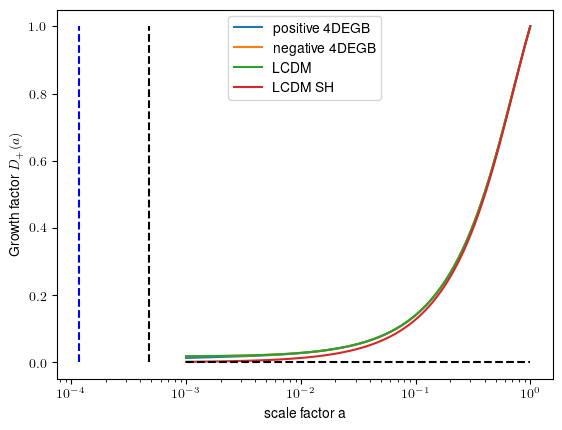

In [805]:
# TEST Integrator works the right way
cosmo_LCDM_array = [0.27 , 0.045,  0,9.227e-5 , 0]
cosmo = [0.27 , 0.045,  0,9.227e-5 , 3e-6]
cosmo1 = [0.27 , 0.045,  0,9.227e-5 , -3e-6]
k_val = 9
a_val = np.logspace(-3,0,100)
print("4DEGB+")
pos_soln =solve_for_growth(a_val, cosmo, [k_val,k_val])[0]
#print(len(pos_soln))
plt.plot(a_val,pos_soln[0], label = "positive 4DEGB")
print("4DEGB-")
plt.plot(a_val,solve_for_growth(a_val, cosmo1, [k_val,k_val])[0][0], label = "negative 4DEGB")
print("LCDM")
plt.plot(a_val,solve_for_growth(a_val, cosmo_LCDM_array, [k_val,k_val])[0][0], label = "LCDM")
print("LCDM Superhorizon approx")
plt.plot(a_val,solve_for_growth_SH(a_val, cosmo_LCDM_array, [k_val,k_val])[0][0], label = "LCDM SH")


plt.plot(a_val,np.zeros(len(a_val)), "k--")
plt.plot(np.ones(10)*np.sqrt(6*cosmo[-1]/k_val**2), np.linspace(0,1,10), "k--")
plt.plot(np.ones(10)*np.sqrt(6*cosmo[-1]/(k_val**2+ 3*(Easquared(np.min(a_val),cosmo1)/np.min(a_val))**2)), np.linspace(0,1,10), "b--")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel("scale factor a")
plt.ylabel(r"Growth factor $D_+(a)$")
plt.legend()
#plt.ylim(-0.1,0.1)
#plt.savefig("negativegrowth.pdf")

4DEGB+
4DEGB-
LCDM
LCDM Superhorizon approx


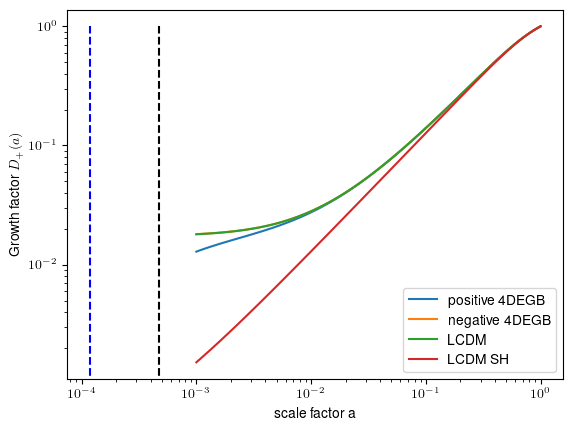

In [806]:
# TEST Integrator works the right way
cosmo_LCDM_array = [0.27 , 0.045,  0,9.227e-5 , 0]
cosmo = [0.27 , 0.045,  0,9.227e-5 , 3e-6]
cosmo1 = [0.27 , 0.045,  0,9.227e-5 , -3e-6]
k_val = 9
a_val = np.logspace(-3,0,100)
print("4DEGB+")
pos_soln =solve_for_growth(a_val, cosmo, [k_val,k_val])[0]
#print(len(pos_soln))
plt.plot(a_val,pos_soln[0], label = "positive 4DEGB")
print("4DEGB-")
plt.plot(a_val,solve_for_growth(a_val, cosmo1, [k_val,k_val])[0][0], label = "negative 4DEGB")
print("LCDM")
plt.plot(a_val,solve_for_growth(a_val, cosmo_LCDM_array, [k_val,k_val])[0][0], label = "LCDM")
print("LCDM Superhorizon approx")
plt.plot(a_val,solve_for_growth_SH(a_val, cosmo_LCDM_array, [k_val,k_val])[0][0], label = "LCDM SH")


plt.plot(a_val,np.zeros(len(a_val)), "k--")
plt.plot(np.ones(10)*np.sqrt(6*cosmo[-1]/k_val**2), np.linspace(0,1,10), "k--")
plt.plot(np.ones(10)*np.sqrt(6*cosmo[-1]/(k_val**2+ 3*(Easquared(np.min(a_val),cosmo1)/np.min(a_val))**2)), np.linspace(0,1,10), "b--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("scale factor a")
plt.ylabel(r"Growth factor $D_+(a)$")
plt.legend()
#plt.ylim(-0.1,0.1)
#plt.savefig("negativegrowth.pdf")

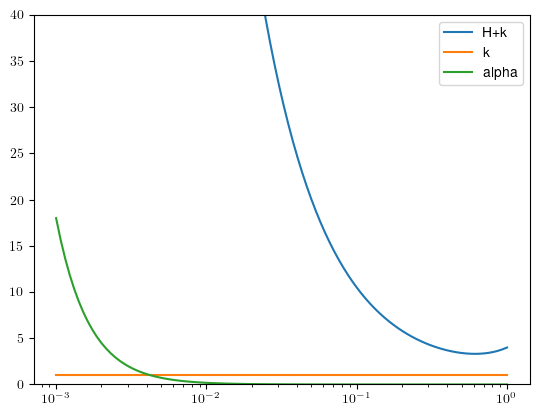

In [807]:
k_val = 1
plt.plot(a_val, 3*(Easquared(a_val,cosmo)/a_val)**2 + k_val**2, label = "H+k")
plt.plot(a_val, k_val**2 * np.ones(len(a_val)), label = "k")
plt.plot(a_val, 6*cosmo[-1]/a_val**2, label = "alpha")
plt.legend()
plt.ylim(0,40)
plt.xscale("log")

4DEGB+
4DEGB-
LCDM
LCDM Superhorizon approx


/tmp/ipykernel_1843258/3557442952.py:18: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.ones(100)*np.sqrt(6*cosmo[-1]*1101**2 - 3*(Easquared(1/1101,cosmo)*1101)**2), np.linspace(-0.5,0.5,100))


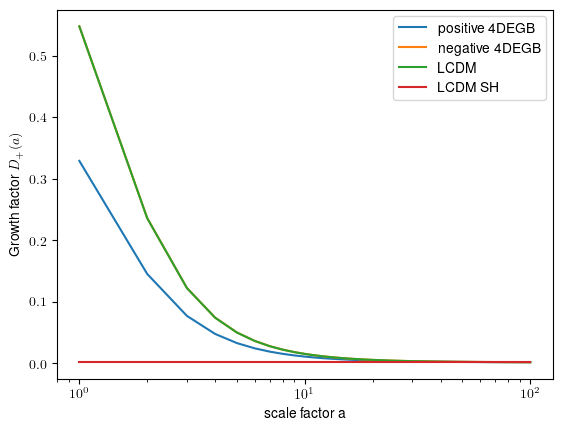

In [808]:
# TEST Integrator works the right way
cosmo_LCDM_array = [0.27 , 0.045,  0,9.227e-5 , 0]
cosmo = [0.27 , 0.045,  0,9.227e-5 , 3e-6]
cosmo1 = [0.27 , 0.045,  0,9.227e-5 , -3e-6]
k_val = np.linspace(1,100,100)
a_val = np.array([1/1101,1])
print("4DEGB+")
pos_soln =solve_for_growth(a_val, cosmo, k_val)[0].T
#print(len(pos_soln))
plt.plot(k_val,pos_soln[0], label = "positive 4DEGB")
print("4DEGB-")
plt.plot(k_val,solve_for_growth(a_val, cosmo1, k_val)[0].T[0], label = "negative 4DEGB")
print("LCDM")
plt.plot(k_val,solve_for_growth(a_val, cosmo_LCDM_array, k_val)[0].T[0], label = "LCDM")
print("LCDM Superhorizon approx")
plt.plot(k_val,solve_for_growth_SH(a_val, cosmo_LCDM_array, k_val)[0].T[0], label = "LCDM SH")

plt.plot(np.ones(100)*np.sqrt(6*cosmo[-1]*1101**2 - 3*(Easquared(1/1101,cosmo)*1101)**2), np.linspace(-0.5,0.5,100))


plt.xscale("log")
#plt.yscale("log")
plt.xlabel("scale factor a")
plt.ylabel(r"Growth factor $D_+(a)$")
plt.legend()
#plt.ylim(-0.1,0.1)
#plt.savefig("negativegrowth.pdf")

# Get plots for D+, f and fsigma8

In [944]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.logspace(-2, -1, 300)*(3e5/100)

# Decide on some coordinate times
z_val = np.linspace(0,1300,1000)
a_val = 1/(z_val+1)
# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , -1e-5]
cosmo_pos = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")

error in k_simga8 =  87.26760455264838 %


In [945]:
solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

solution_growth_pos = solve_for_growth(a_val, cosmo_pos, k_val)


## First attempts

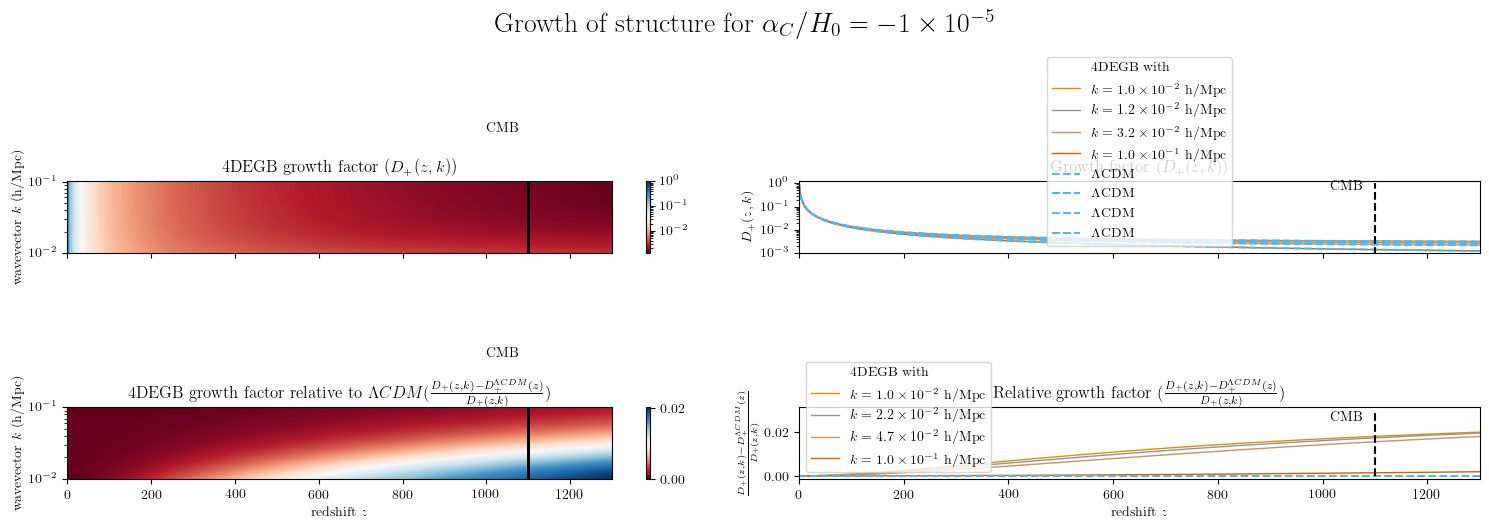

In [919]:
"""Linear Growth factor D+(a) plots"""

fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1100 - 1, 1101 + 1] , k_val/(3e5/100))

# PLOT OF RELATIVE D+(a)
ax = axs[1][0]
#print(solution_growth[0])
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'$\textrm{4DEGB growth factor relative to }\Lambda CDM (\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r'$\textrm{wavevector }k\textrm{ (h/Mpc)}$')
# Line for CMB
c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(1000, 0.5, r"$\textrm{CMB}$")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'$\textrm{redshift }z$')

# PLOTS OF D+(a) OF 4DEGB AND LCDM
ax = axs[0][0]
Z = solution_growth[0]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, alpha = 1,norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='RdBu')
## Line to help distinguish LCDM and 4DEGB
#c2 = ax.pcolor(X_blackline, Y_blackline, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
#c2 = ax.pcolor(X_blackline1, Y_blackline1, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
## An example of LCDM equivalent plots
#c1 = ax.pcolor(X_ex1, Y_ex1, solution_growth_LCDM_ex1[0],norm=LogNorm(vmin=Z.min(), vmax=Z.max()), cmap='RdBu', \
#              alpha = 1)
# Line for 8 Mpc/h ---- TODO ------------------------------------------------------------------------------------
#c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(0.15, 8e3, r"$k = 8 Mpc/h$")
# Line for CMB
c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(1000, 0.5, r"$\textrm{CMB}$")

ax.set_title(r'$\textrm{4DEGB growth factor }(D_{+}(z,k))$')
ax.set_ylabel(r'$\textrm{wavevector }k\textrm{ (h/Mpc)}$')
ax.set_yscale("log")
fig.colorbar(c, ax=ax)

# 2D PLOTS OF D+(a)
ax = axs[0][1]
ax.plot(1,0, alpha = 0, label = r"$\textrm{4DEGB with}$")
ax.plot(z_val, Z[0], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-280]/3000)-int(np.log10(k_val[-200]/3000)-1e-8)+1), int(np.log10(k_val[-200]/3000)-1e-8)-1)\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-150]/3000)-int(np.log10(k_val[-100]/3000) -1e-8)+1), int(np.log10(k_val[-100]/3000)-1e-8)-1)\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][0], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
ax.plot(z_val, solution_growth_LCDM[0][-280], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
ax.plot(z_val, solution_growth_LCDM[0][-250], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
ax.plot(z_val, solution_growth_LCDM[0][-1], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
#CMB
ax.plot(1100*np.ones(len(z_val)), np.linspace(1e-4,1,len(z_val)), linestyle = "--", color = "k")
ax.text(1015, 0.5, r"$\textrm{CMB}$")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_ylim(1e-3,1.2)
ax.set_title(r'$\textrm{Growth factor }(D_{+}(z,k))$')
ax.set_yscale("log")

ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs[1][1]
ax.plot(1,0, alpha = 0, label = r"\textrm{4DEGB with}")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-1e-8)), int(np.log10(k_val[0]/3000)-1e-8))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-1e-8) + 1), int(np.log10(k_val[-200]/3000)-1e-8)-1)\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -1e-8) + 1), int(np.log10(k_val[-100]/3000)-1e-8)-1)\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000))), int(np.log10(k_val[-1]/3000)))\
        , linewidth =1, color = col[3])

ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
ax.plot(1100*np.ones(len(z_val)), np.linspace(0,0.03,len(z_val)), linestyle = "--", color = "k")
ax.text(1015, 0.025, r"$\textrm{CMB}$")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'$\textrm{Relative growth factor }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"$\textrm{redshift }z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
fig.tight_layout()
fig.suptitle(r'$\textrm{Growth of structure for }\alpha_C/H_0 = %.0f \times 10^{%d}$' % ((cosmo[-1]/np.abs(cosmo[-1]))*10**(np.log10(np.abs(cosmo[-1]))-int(np.log10(np.abs(cosmo[-1]))-0.1)), int(np.log10(np.abs(cosmo[-1]))-0.1)),fontsize=20, y=1.05)
#plt.savefig("D_positive_aC_CMB.pdf")
plt.show()

/tmp/ipykernel_1843258/1434166733.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((5, 2), (3, 0), colspan=2)
/tmp/ipykernel_1843258/1434166733.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((5, 2), (4, 0), colspan=2)
/tmp/ipykernel_1843258/1434166733.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((5, 2), (1, 0))
/tmp/ipykernel_1843258/1434166733.py:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax =

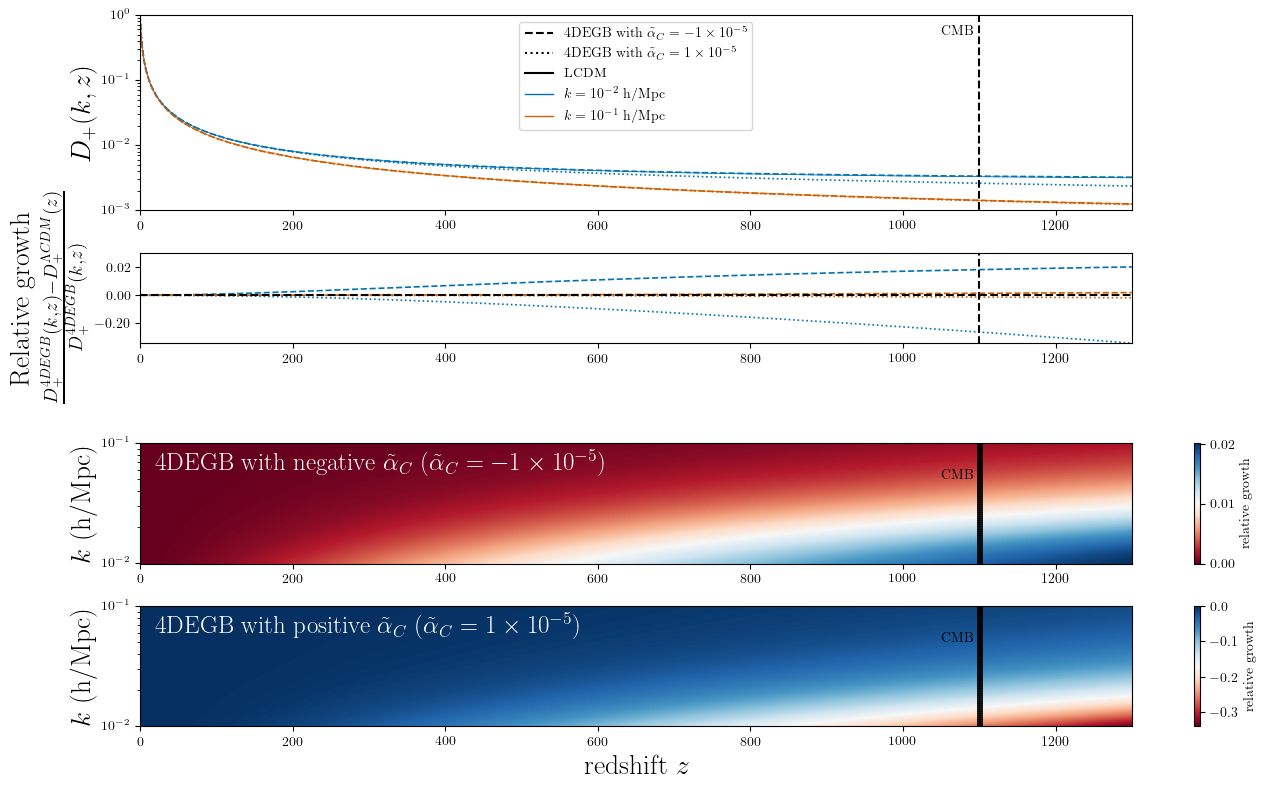

In [1033]:
"""PAPER"""

# Now that the Scale class has been defined, it must be registered so
# that ``matplotlib`` can find it.
mscale.register_scale(AsymScale)


fig, axs = plt.subplots(5, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [13,6,1,8,8],'width_ratios': [1,0.235]}, sharex=True)

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1100 - 1, 1101 + 1] , k_val/(3e5/100))

# PLOT OF RELATIVE D+(a) - neg
ax = plt.subplot2grid((5, 2), (3, 0), colspan=2)
ax.text(20,0.06,r"$\textrm{4DEGB with negative } \tilde{\alpha}_C \textrm{ }(\tilde{\alpha}_C = %.0f \times 10^{%d})$" %\
             ((cosmo[-1]/np.abs(cosmo[-1]))*10**(np.log10(np.abs(cosmo[-1]))-int(np.log10(np.abs(cosmo[-1]))-0.1)), int(np.log10(np.abs(cosmo[-1]))-0.1)),color="w",fontsize=18)
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
#x.set_title(r'$\textrm{Relative growth factor }(\frac{D_{+}^{4DEGB}(k,z) - D_{+}^{\Lambda CDM}(z)}{D_{+}^{4DEGB}(k,z)}) \textrm{ as a function of }z\textrm{ and }k$')
ax.set_ylabel(r'$k\textrm{ (h/Mpc)}$',fontsize=20)
# Line for CMB
c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(1050, 0.05, r"$\textrm{CMB}$")
fig.colorbar(c, ax=ax,location="right", pad =0.05, shrink=1,label=r"$\textrm{relative growth}$")
ax.set_yscale("log")
ax.set_xlim(0,1300)

# PLOT OF RELATIVE D+(a) - pos
ax = plt.subplot2grid((5, 2), (4, 0), colspan=2)
ax.text(20,0.06,r"$\textrm{4DEGB with positive } \tilde{\alpha}_C \textrm{ }(\tilde{\alpha}_C = %.0f \times 10^{%d})$" %\
             ((cosmo_pos[-1]/np.abs(cosmo_pos[-1]))*10**(np.log10(np.abs(cosmo_pos[-1]))-int(np.log10(np.abs(cosmo_pos[-1]))-0.1)), int(np.log10(np.abs(cosmo_pos[-1]))-0.1)),color="w",fontsize=18)

Z = (solution_growth_pos[0]-solution_growth_LCDM[0])/solution_growth_pos[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
#x.set_title(r'$\textrm{Relative growth factor }(\frac{D_{+}^{4DEGB}(k,z) - D_{+}^{\Lambda CDM}(z)}{D_{+}^{4DEGB}(k,z)}) \textrm{ as a function of }z\textrm{ and }k$')
ax.set_ylabel(r'$k\textrm{ (h/Mpc)}$',fontsize=20)
# Line for CMB
c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(1050, 0.05, r"$\textrm{CMB}$")
fig.colorbar(c, ax=ax,location="right", pad =0.05, shrink=1, label=r"$\textrm{relative growth}$")
ax.set_yscale("log")
ax.set_xlabel(r'$\textrm{redshift }z$',fontsize=20)
ax.set_xlim(0,1300)


# 2D PLOTS OF RELATIVE D+(a)
ax = plt.subplot2grid((5, 2), (1, 0))

Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
Z_pos = (solution_growth_pos[0]-solution_growth_LCDM[0])/solution_growth_pos[0]
#Neg
ax.plot(z_val, Z[0], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-1e-8)), int(np.log10(k_val[0]/3000)-1e-8))\
        , linewidth =1.2, color = col[0], linestyle = "--")
ax.plot(z_val, Z[-1], label = r"$k = %.1f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000))), int(np.log10(k_val[-1]/3000)))\
        , linewidth =1.2, color = col[3], linestyle = "--")
#Pos
ax.plot(z_val, Z_pos[0] , int(np.log10(k_val[0]/3000)-1e-8)\
        , linewidth =1.2, color = col[0], linestyle = "dotted")
ax.plot(z_val, Z_pos[-1],int(np.log10(k_val[-1]/3000))\
        , linewidth =1.2, color = col[3], linestyle = "dotted")

#LCDM
ax.plot(z_val, np.zeros(len(z_val)), color = "k", linestyle = "--")
#CMB
ax.plot(1100*np.ones(len(z_val)), np.linspace(-0.5,0.1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1050, 0.022, r"$\textrm{CMB}$")

# Make y axis have a different + and - scale
forward, inverse = get_scale(a=1/10)
ax.set_yscale('function', functions=(forward, inverse))  # this is for setting x axis
plt.yticks(ticks=[-0.2, 0,0.02])
#x.set_title(r'$\textrm{Relative growth factor }(\frac{D_{+}^{4DEGB}(k,z) - D_{+}^{\Lambda CDM}(z)}{D_{+}^{4DEGB}(k,z)})$')
ax.set_ylabel(r"$\textrm{Relative growth }$""\n" r"$\frac{D_{+}^{4DEGB}(k,z) - D_{+}^{\Lambda CDM}(z)}{D_{+}^{4DEGB}(k,z)}$",fontsize=20)
ax.set_xlim(0,1300)
ax.set_ylim(-0.340,0.030)

# 2D PLOTS OF D+(a)
ax = plt.subplot2grid((5, 2), (0, 0))
Z = solution_growth[0]
Z_pos = solution_growth_pos[0]
#TITLES
l1 = ax.plot(1,0, alpha = 1, label = r"$\textrm{4DEGB with } \tilde{\alpha}_C = %.0f \times 10^{%d}$" %\
             ((cosmo[-1]/np.abs(cosmo[-1]))*10**(np.log10(np.abs(cosmo[-1]))-int(np.log10(np.abs(cosmo[-1]))-0.1)), int(np.log10(np.abs(cosmo[-1]))-0.1)), color="k", linestyle = "--")
l2= ax.plot(1,0, alpha = 1, linestyle="dotted", label = r"$\textrm{4DEGB with } \tilde{\alpha}_C = %.0f \times 10^{%d}$" %\
             ((cosmo_pos[-1]/np.abs(cosmo_pos[-1]))*10**(np.log10(np.abs(cosmo_pos[-1]))-int(np.log10(np.abs(cosmo_pos[-1]))-0.1)), int(np.log10(np.abs(cosmo_pos[-1]))-0.1)), color="k")
l2 = ax.plot(1,0, "k",alpha = 1, label = r"$\textrm{LCDM}$")
l2 = ax.plot(1,0, label = r"$k = 10^{%d} \textrm{ h/Mpc}$" % (int(np.log10(k_val[0]/3000)-0.1)), linewidth =1, color = col[0])
l2 = ax.plot(1,0, label = r"$k =10^{%d} \textrm{ h/Mpc}$" % (int(np.log10(k_val[-1]/3000)-0.1)), linewidth =1, color = col[3])

#Neg
ax.plot(z_val, Z[0], color = col[0], linestyle ="--", linewidth =1.2)
ax.plot(z_val, Z[-1], color = col[3], linestyle ="--", linewidth =1.2)

#Pos
ax.plot(z_val, Z_pos[0] , int(np.log10(k_val[0]/3000)-1e-8)\
        , linewidth =1.2, color = col[0], linestyle = "dotted")
ax.plot(z_val, Z_pos[-1],int(np.log10(k_val[-1]/3000))\
        , linewidth =1.2, color = col[3], linestyle = "dotted")

#LCDM
ax.plot(z_val, solution_growth_LCDM[0][0], color = col[0], linewidth =0.6)
ax.plot(z_val, solution_growth_LCDM[0][-1], color = col[3], linewidth =0.6)
#CMB
ax.plot(1100*np.ones(len(z_val)), np.linspace(1e-4,1,len(z_val)), linestyle = "--", color = "k")
ax.text(1050, 0.5, r"$\textrm{CMB}$")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(k,z)$",fontsize=20)
ax.set_ylim(1e-3,1)
ax.set_xlim(0,1300)
#x.set_title(r'$\textrm{Growth factor }(D_{+}(k,z))$')
ax.set_yscale("log")
ax.legend()

fig.delaxes(plt.subplot2grid((5, 2), (0, 1)))
fig.delaxes(plt.subplot2grid((5, 2), (1, 1)))


fig.delaxes(plt.subplot2grid((5, 2), (2, 0)))
fig.delaxes(plt.subplot2grid((5, 2), (2, 1)))

#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
fig.tight_layout()
#fig.suptitle(r'$\textrm{Growth of structure for }\tilde{\alpha}_C = %.0f \times 10^{%d}$' % ((cosmo[-1]/np.abs(cosmo[-1]))*10**(np.log10(np.abs(cosmo[-1]))-int(np.log10(np.abs(cosmo[-1]))-0.1)), int(np.log10(np.abs(cosmo[-1]))-0.1)),fontsize=20, y=1.05)
#plt.savefig("D_aC_CMB.pdf")
plt.show()

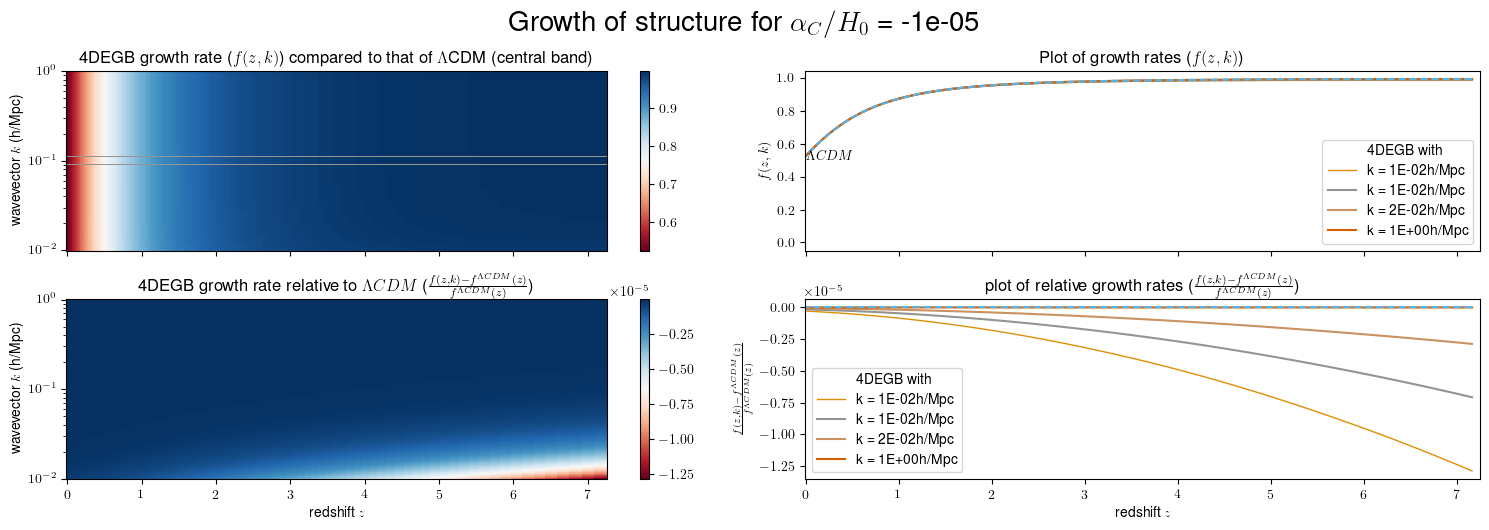

In [244]:
"""Linear Growth rate f(a) plots"""
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/3000)
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/3000)
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/3000,k_val[int(len(k_val)/2)-6]/3000])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/3000,k_val[int(len(k_val)/2)+6]/3000])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [3e5*np.pi/400+0.5, 3e5*np.pi/400 -0.5])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/3000)

# PLOT OF RELATIVE f(a)
ax = axs[1][0]
Z = (solution_growth[1]-solution_growth_LCDM[1])/solution_growth[1]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'4DEGB growth rate relative to $\Lambda CDM$ ($\frac{f(z,k) - f^{\Lambda CDM}(z)}{f^{\Lambda CDM}(z)}$)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'redshift $z$')

# PLOTS OF f(a) OF 4DEGB AND LCDM
ax = axs[0][0]
Z = solution_growth[1]
# Plot of 4DEGB growth factor
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# Black line to help distinguish LCDM and 4DEGB
c2 = ax.pcolor(X_blackline, Y_blackline, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
c2 = ax.pcolor(X_blackline1, Y_blackline1, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
# An example of LCDM equivalent plots
c1 = ax.pcolor(X_ex1, Y_ex1, solution_growth_LCDM_ex1[1],vmin=Z.min(), vmax=Z.max(), \
              alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h
#c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(0.15, 8e3, r"$k = 8 Mpc/h$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_title(r'4DEGB growth rate ($f(z,k)$) compared to that of $\Lambda$CDM (central band)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
ax.set_yscale("log")
fig.colorbar(c, ax=ax)

# 2D PLOTS OF f(a)
ax = axs[0][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, solution_growth_LCDM[1][int(len(k_val)/2)], color = col[9], linestyle = "--")
ax.text(0.7e-4, 0.5, r"$\Lambda CDM$")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

ax.set_ylabel(r"$f(z,k)$")
ax.set_title(r'Plot of growth rates ($f(z,k)$)')
ax.legend()

# 2D PLOTS OF RELATIVE f(a)
ax = axs[1][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = (solution_growth[1]-solution_growth_LCDM[1])/solution_growth_LCDM[1]
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(a_val)), np.linspace(-1,0,len(a_val)), linestyle = "--", color = "k")
#ax.text(1e-3, -0.5, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'plot of relative growth rates ($\frac{f(z,k) - f^{\Lambda CDM}(z)}{f^{\Lambda CDM}(z)}$)')
ax.set_ylabel(r"$\frac{f(z,k) - f^{\Lambda CDM}(z)}{f^{\Lambda CDM}(z)}$")
ax.set_xlabel(r"redshift $z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(a_val))))
fig.tight_layout()
fig.suptitle(r'Growth of structure for $\alpha_C/H_0$ = {}'.format(cosmo[-1]), fontsize=20, y=1.05)
plt.show()

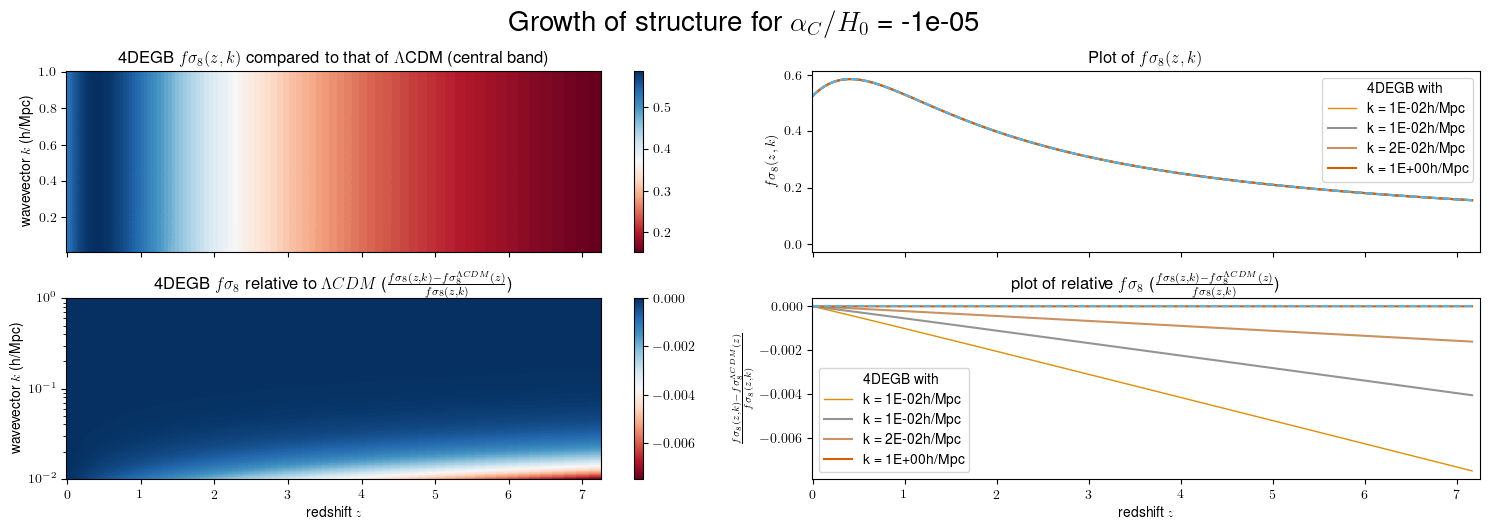

In [245]:
"""Linear fsigma8 plots"""
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

col = sns.color_palette("colorblind")
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/3000)
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/3000)
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/3000,k_val[int(len(k_val)/2)-6]/3000])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/3000,k_val[int(len(k_val)/2)+6]/3000])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [3e5*np.pi/400+0.5, 3e5*np.pi/400 -0.5])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/3000)

# PLOT OF RELATIVE fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h)
ax = axs[1][0]
Z = (solution_growth[1]*solution_growth[0][idx_sigma]-solution_growth_LCDM[1]*solution_growth_LCDM[0])/(solution_growth[1]*solution_growth[0][idx_sigma])
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'4DEGB $f\sigma_8$ relative to $\Lambda CDM$ ($\frac{f\sigma_8(z,k) - f\sigma_8^{\Lambda CDM}(z)}{f\sigma_8(z,k)}$)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
fig.colorbar(c, ax=ax)
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_yscale("log")
ax.set_xlabel(r'redshift $z$')

# PLOTS OF fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h) FOR 4DEGB AND LCDM
ax = axs[0][0]
Z = solution_growth[1]*solution_growth[0][idx_sigma]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# An example of LCDM equivalent plots
c1 = ax.pcolor(X_ex1, Y_ex1, solution_growth_LCDM_ex1[1]*solution_growth_LCDM_ex1[0],vmin=Z.min(), vmax=Z.max(), \
              alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h
#c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(0.15, 8e3, r"$k = 8 Mpc/h$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
# Black line to help distinguish LCDM and 4DEGB
#c2 = ax.pcolor(X_blackline, Y_blackline, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
#c2 = ax.pcolor(X_blackline1, Y_blackline1, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')

ax.set_title(r'4DEGB $f\sigma_8(z,k)$ compared to that of $\Lambda$CDM (central band)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
fig.colorbar(c, ax=ax)

# 2D PLOTS OF fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h)
ax = axs[0][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = solution_growth[1]*solution_growth[0][idx_sigma]
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, solution_growth_LCDM[1][int(len(k_val)/2)]*solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--")
#ax.text(1e-4, 0.5e-3, r"$\Lambda CDM$")
#CMB
#ax.plot(1/1101*np.ones(len(a_val)), np.linspace(0,1,len(a_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

ax.set_ylabel(r"$f\sigma_8(z,k)$")
ax.set_title(r'Plot of $f\sigma_8(z,k)$')
ax.legend()

# 2D PLOTS OF RELATIVE fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h)
ax = axs[1][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = (solution_growth[1]*solution_growth[0][idx_sigma]-solution_growth_LCDM[1]*solution_growth_LCDM[0])/(solution_growth[1]*solution_growth[0][idx_sigma])
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, np.zeros(len(a_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(a_val)), np.linspace(-50,0,len(a_val)), linestyle = "--", color = "k")
#ax.text(1e-3, -50, r"CMB")

#ax.plot(a_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'plot of relative $f\sigma_8$ ($\frac{f\sigma_8(z,k) - f\sigma_8^{\Lambda CDM}(z)}{f\sigma_8(z,k)}$)')
ax.set_ylabel(r"$\frac{f\sigma_8(z,k) - f\sigma_8^{\Lambda CDM}(z)}{f\sigma_8(z,k)}$")
ax.set_xlabel(r"redshift $z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(a_val))))
fig.tight_layout()
fig.suptitle(r'Growth of structure for $\alpha_C/H_0$ = {}'.format(cosmo[-1]), fontsize=20, y=1.05)
plt.show()

## Paper plots

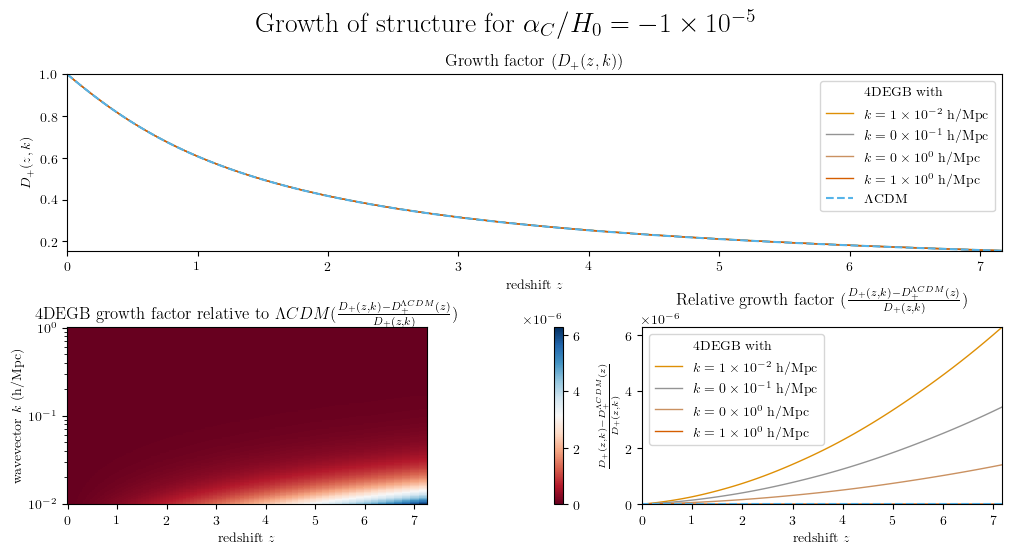

In [240]:
"""Linear Growth factor D+(a) plots"""

#fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axs = fig.subplot_mosaic([['Top', 'Top'],['BLeft', 'BRight']],
                          gridspec_kw={'width_ratios':[1, 1]})

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

# PLOTS OF D+(a) OF 4DEGB AND LCDM
ax = axs['BLeft']
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'$\textrm{4DEGB growth factor relative to }\Lambda CDM (\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r'$\textrm{wavevector }k\textrm{ (h/Mpc)}$')
# Line for CMB
c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1000, 0.0, r"$\textrm{CMB}$")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'$\textrm{redshift }z$')

#ax.text(0.15, 5e-1, r"$k = \frac{2 \pi}{8\textrm{Mpc/h}}$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

# 2D PLOTS OF D+(a)
ax = axs['Top']
Z =solution_growth[0]
ax.plot(1,0, alpha = 0, label = r"$\textrm{4DEGB with}$")
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(solution_growth_LCDM[0][int(len(k_val)/2)][0],solution_growth_LCDM[0][int(len(k_val)/2)][-1])
ax.set_title(r'$\textrm{Growth factor }(D_{+}(z,k))$')
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs['BRight']
ax.plot(1,0, alpha = 0, label = r"\textrm{4DEGB with}")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.9, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'$\textrm{Relative growth factor }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(Z[0][-1],Z[0][0])
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
#fig.tight_layout()
fig.suptitle(r'$\textrm{Growth of structure for }\tilde{\alpha}_C = %.0f \times 10^{%d}$' % ((cosmo[-1]/np.abs(cosmo[-1]))*10**(np.log10(np.abs(cosmo[-1]))-int(np.log10(np.abs(cosmo[-1]))-0.1)), int(np.log10(np.abs(cosmo[-1]))-0.1)),fontsize=20, y=1.08)
#plt.savefig("D_negative_aC.pdf", bbox_inches='tight')
plt.show()

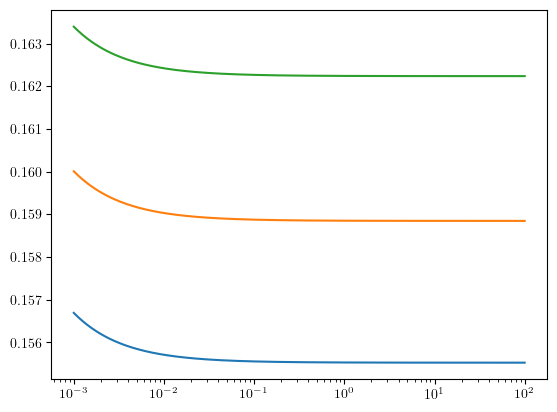

In [315]:
Z =solution_growth[0]
plt.plot(k_val, Z[:,0])
plt.plot(k_val, Z[:,1])
plt.plot(k_val, Z[:,2])
plt.xscale("log")

# Finding how the peak of fsigma8 varies with alpha_C

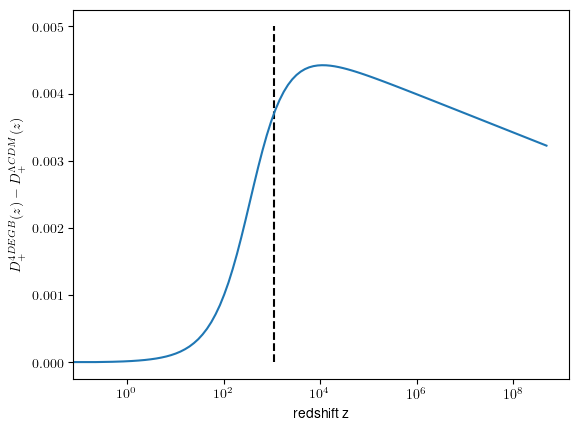

In [494]:
# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , -1e-5]
k = 0.001*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -20, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1
# At some characteristic scale. We choose scale k = 8 Mpc/h
solution_growth_ex = solve_for_growth(a_val, cosmo, np.array([(3e5*np.pi/400),k]))
solution_growth_LCDM_ex = solve_for_growth(a_val, cosmo_LCDM_array, np.array([1,1]))

Z = (solution_growth_ex[0]-solution_growth_LCDM_ex[0])
toeval = Z[1]

plt.plot(1101*np.ones(len(a_val)), np.linspace(0,0.005,len(a_val)), linestyle = "--", color = "k")
plt.plot(z_val, toeval)
plt.xlabel("redshift z")
plt.ylabel(r"$D_+^{4DEGB}(z) - D_+^{\Lambda CDM}(z)$")
plt.xscale("log")

# Comparing early universe and late universe S8

## Getting and processing the data

-5.154977281325498e-06
Max predicted sigma8 from 4DEGB =  0.8675925999962296
Min predicted sigma8 from 4DEGB =  0.8198919243064619
mean1 =  0.8630826037126575
mean2 =  0.8573607789472925


/tmp/ipykernel_1843258/3477370914.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  avg_S8 = sc.integrate.quad(lambda x: np.interp(x, k_val, simga8_z_4DEGB_try[:,-1]),\


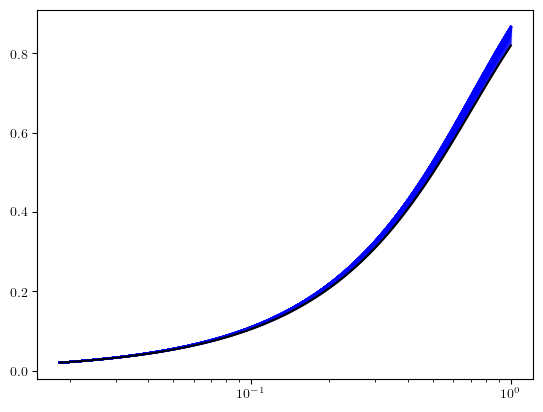

In [21]:
# All data values from
# S8 from CMB assuming LCDM (Planck) = 0.834 ± 0.016

# S8 from KiDS-450 = 0.745 ± 0.039
# S8 from KiDS-450+2dFLenS = 0.742 ± 0.035
# S8 from KV450 = 0.737^{+0.040}_{−0.036}
# S8 from DES = 0.783^{+0.021}_{−0.025}
# S8 from KiDS-1000 = = 0.766^{+0.020}_{−0.014}
N_eff = 2.8
dN_eff = N_eff - 3.046
Omg_r = (1 + (7/8) * (4/11)**(4/3)*N_eff)*9.227e-5
Omg_r_LCDM = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5
cosmo = [0.27 , 0.045, 0 ,Omg_r , Omg_r - Omg_r_LCDM]
cosmo_LCDM_array = [0.27 , 0.045, 0 ,Omg_r , 0.0]
print(Omg_r - Omg_r_LCDM)
k_val = np.logspace(-2, -1, 300)*(3e5/100)
# Decide on some coordinate times
x_val = np.linspace( -4, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)

sigma80_CMB_LCDM = 0.82
simga8_z_LCDM_try = solution_growth_LCDM[0][0]*sigma80_CMB_LCDM
simga8_atCMB_LCDM = np.interp(1/1101, a_val, simga8_z_LCDM_try)

simga8_z_4DEGB_try = np.zeros((len(k_val), len(a_val)))

for i in range(len(k_val)):
    simga8_z_4DEGB_try[i] = solution_growth[0][i]*simga8_atCMB_LCDM/\
                 np.interp(1/1101, a_val, solution_growth[0][i])
    plt.plot(a_val,simga8_z_4DEGB_try[i], color = "b", alpha = 0.1)

print("Max predicted sigma8 from 4DEGB = ",max(simga8_z_4DEGB_try[:,-1]))
print("Min predicted sigma8 from 4DEGB = ",min(simga8_z_4DEGB_try[:,-1]))

avg_S8 = sc.integrate.quad(lambda x: np.interp(x, k_val, simga8_z_4DEGB_try[:,-1]),\
                           k_val[0], k_val[-1])/((k_val[-1] - k_val[0]))

print("mean1 = ", avg_S8[0])
print("mean2 = ", np.mean(simga8_z_4DEGB_try[:,-1]))

plt.plot(a_val,simga8_z_LCDM_try, color = "black")

plt.xscale("log")


24260


NameError: name 'line' is not defined

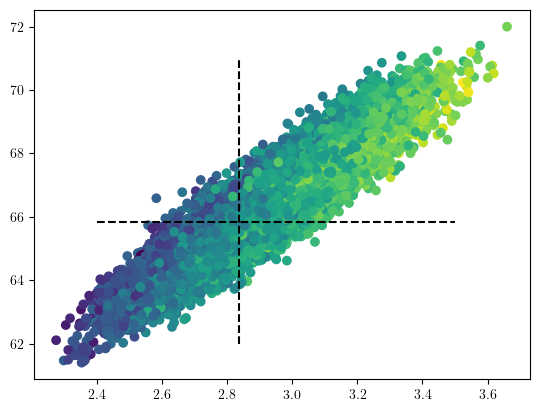

In [22]:
# Import the datafiles
content1 = pd.read_table('base_nnu_plikHM_TTTEEE_lowl_lowE_1.txt', delim_whitespace=True, header=None)
content2 = pd.read_table('base_nnu_plikHM_TTTEEE_lowl_lowE_2.txt', delim_whitespace=True, header=None)
content3 = pd.read_table('base_nnu_plikHM_TTTEEE_lowl_lowE_3.txt', delim_whitespace=True, header=None)
content4 = pd.read_table('base_nnu_plikHM_TTTEEE_lowl_lowE_4.txt', delim_whitespace=True, header=None)

# get data for N_eff, sigma_8 and H_0
# N_eff = array[6+1], H_0 = array[30+1], sigma8 = array[36+1]

# This means the first two are probably not params, given there are 99 in total

N_eff = np.append(np.append(np.append(content1[6],content2[6]),content3[6]),content4[6])
H0 = np.append(np.append(np.append(content1[30],content2[30]),content3[30]),content4[30])
w_b = np.append(np.append(np.append(content1[2],content2[2]),content3[2]),content4[2])
w_c = np.append(np.append(np.append(content1[3],content2[3]),content3[3]),content4[3])
sigma8 = np.append(np.append(np.append(content1[36],content2[36]),content3[36]),content4[36])
Omega_m_Planck = np.append(np.append(np.append(content1[32],content2[32]),content3[32]),content4[32])
A_s = np.append(np.append(np.append(content1[44],content2[44]),content3[44]),content4[44])*1e-9
n_s = np.append(np.append(np.append(content1[8],content2[8]),content3[8]),content4[8])

print(len(N_eff))

del content1, content2,content3,content4
fig, ax = plt.subplots()

scatter = ax.scatter(N_eff,H0, c=sigma8)
ax.plot(np.linspace(2.4,3.5,2), [0.6582275E+02,0.6582275E+02],"k--")
ax.plot([0.2835882E+01,0.2835882E+01], np.linspace(62,71,2),"k--")
ax.plot(line[:, 0], line[:, 1], 'r')
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$H_{0}$")
cbar = fig.colorbar(scatter)
cbar.set_label(r'$\sigma_8$', rotation=270)

NameError: name 'line' is not defined

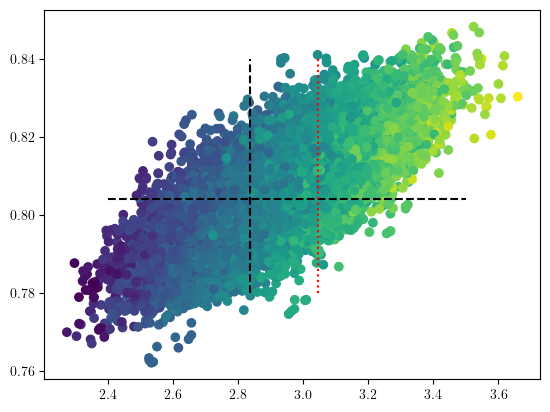

In [402]:
fig, ax = plt.subplots()

scatter = ax.scatter(N_eff,sigma8, c=H0)
ax.plot(np.linspace(2.4,3.5,2), [0.8040223,0.8040223],"k--")
ax.plot([0.2835882E+01,0.2835882E+01], np.linspace(0.78,0.84,2),"k--")
ax.plot([0.3046E+01,0.3046E+01], np.linspace(0.78,0.84,2),"r:")
ax.plot(line[:, 0], line[:, 2], 'r')
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$\sigma_{8}$")
cbar = fig.colorbar(scatter)
cbar.set_label(r'$H_0$', rotation=270)

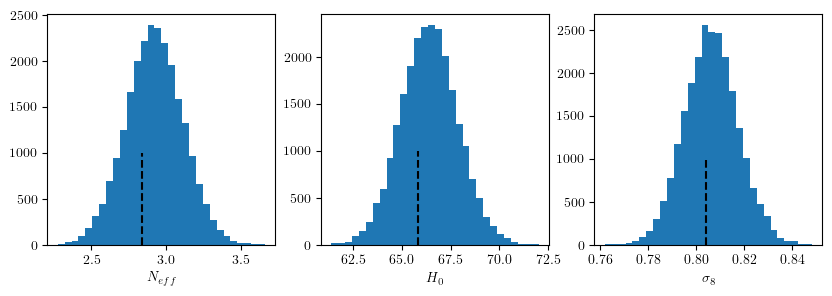

In [403]:
fig, ax = plt.subplots(1,3, figsize = (10,3))

ax[0].hist(N_eff, bins=30)
ax[0].set_xlabel(r"$N_{eff}$")
ax[0].plot([0.2835882E+01,0.2835882E+01], [0,1000],"k--")
ax[1].hist(H0, bins=30)
ax[1].plot([0.6582275E+02,0.6582275E+02], [0,1000],"k--")
ax[1].set_xlabel(r"$H_0$")
ax[2].hist(sigma8, bins=30)
ax[2].set_xlabel(r"$\sigma_8$")
ax[2].plot([0.8040223,0.8040223], [0,1000],"k--")

fig.show()

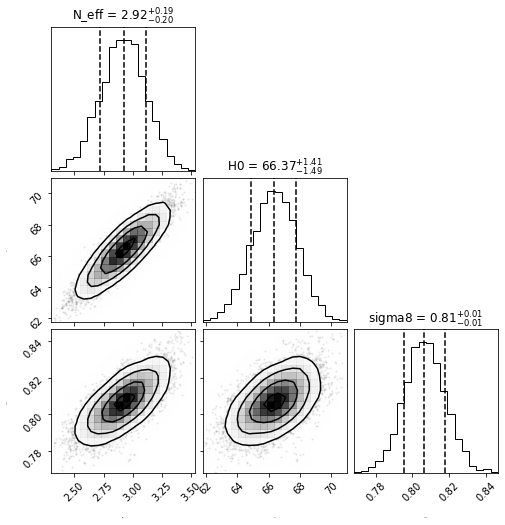

In [6]:
flat_samples = np.array([N_eff,H0,sigma8]).T
fig = corner.corner(
    flat_samples, labels=["N_eff","H0","sigma8"], show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True
);

In [7]:
coords = np.array((N_eff, H0, sigma8)).T

pca = PCA(n_components=1)
pca.fit(coords)
direction_vector = pca.components_
print(direction_vector)

# Create plot
origin = np.mean(coords, axis=0)
euclidian_distance = np.linalg.norm(coords - origin, axis=1)
extent = np.max(euclidian_distance)

line = np.vstack((origin - (direction_vector * extent)/2,
                  origin + direction_vector * extent))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:,2], alpha =0.1)
ax.plot(line[:, 0], line[:, 1], line[:, 2], 'r')
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$H_{0}$")
ax.set_zlabel(r"$\sigma_8$")

NameError: name 'PCA' is not defined

In [498]:
# Background cosmology for pyccl

Omg_r1 = (1 + (7/8) * (4/11)**(4/3)*(0.2835882E+01-3.046))*2.47282e-5/0.6582275**2
Omg_r_LCDM1 = 2.47282e-5/0.6582275**2
cosmo1 = [0.1172459*1e4/0.6582275E+02**2 , 0.2219369E-01*1e4/0.6582275E+02**2, 0 ,Omg_r1 , Omg_r1 - Omg_r_LCDM1]

cosmo = ccl.core.Cosmology(Omega_c=cosmo1[0],
                               Omega_b=cosmo1[1], 
                               A_s=0.2083124e-8,
                               h = 0.6582275,
                               n_s=0.9579279,
                               Omega_k=0,#cosmo[2], 
                               Omega_g=2.47282e-5/0.6582275**2,
                               Neff = 0.2835882E+01,
                               m_nu_type = "single",
                               m_nu = 0.6000000E-01
                              )

k = np.logspace(-2,7,150) # in Mpc^-1
# Decide on some coordinate times
x = np.linspace( -10, 0 , 100)
a = np.exp(x)

cosmo_val = [0.1172459*1e4/0.6582275E+02**2 , 0.2219369E-01*1e4/0.6582275E+02**2, 0 ,Omg_r1 , 0]
cosmo_val_alph = cosmo1
soln = solve_for_growth(a, cosmo_val, k*(3e5/100)/cosmo["h"])[0].T
soln_alph = solve_for_growth(a, cosmo_val_alph, k*(3e5/100)/cosmo["h"])[0].T

#sigma8_test = np.zeros(len(a))
#sigma8_test_alph = np.zeros(len(a))

sigma8_test = sc.integrate.trapz(k**2 * soln**2 *ccl.power.linear_matter_power(cosmo, k, 1)*\
                           (3*sc.special.spherical_jn(1, k*8/cosmo["h"], derivative=False)/(k*8/cosmo["h"]))**2,\
                           x=k)/(2*np.pi**2)
sigma8_test_alph = sc.integrate.trapz(k**2 *(soln[find_nearest(a, 1/1101)]/soln_alph[find_nearest(a, 1/1101)])**2 * soln_alph**2 *ccl.power.linear_matter_power(cosmo, k, 1)*\
                           (3*sc.special.spherical_jn(1, k*8/cosmo["h"], derivative=False)/(k*8/cosmo["h"]))**2,\
                           x=k)/(2*np.pi**2)

/nobackup/c2042999/miniconda3/envs/4DEGB_venv/lib/python3.11/site-packages/pyccl/core.py:745: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


In [499]:
print(Omg_r1 - 2.47282e-5/0.6933350**2)
print(0.6451439E-03/0.6933350**2)
print((0.6451439E-03/0.6933350**2)/((1 + (7/8) * (4/11)**(4/3)*0.3256184E+01) -1))

2.9101081954546615e-06
0.001342055100134145
0.0018148063113714796


0.0
0.8047705020015877
0.8042760861719951
0.016080731048448305


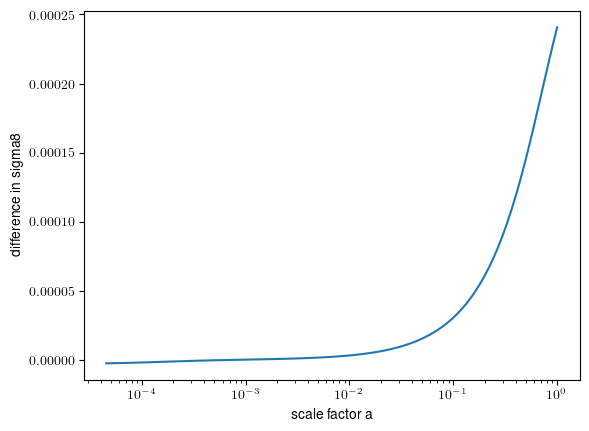

In [500]:
#plt.plot(a,np.sqrt(sigma8_test), color="r", label = "sigma8 LCDM with direct integration")
#plt.plot(a,np.sqrt(sigma8_test_alph), color="b", label = "sigma8 4DEGB with direct integration")
plt.plot(a,-np.sqrt(sigma8_test_alph)+np.sqrt(sigma8_test))
print(-np.sqrt(sigma8_test_alph[find_nearest(a, 1/1101)])+np.sqrt(sigma8_test[find_nearest(a, 1/1101)]))
plt.xscale("log")
plt.xlabel("scale factor a")
plt.ylabel("difference in sigma8")
#plt.yscale("log")
print(np.sqrt(sigma8_test[-1]))
print(ccl.power.sigma8(cosmo))
print((0.8177118-np.sqrt(sigma8_test[-1]))/np.sqrt(sigma8_test[-1]))

In [603]:
# for tests
#N_eff = N_eff[:300]
#sigma8 = sigma8[:300]
#H0 = H0[:300]
# We finf respective cosmologies for N_eff - TODO get correct cosmo params
dN_eff = N_eff - 3.046
Omg_r = (1 + (7/8) * (4/11)**(4/3)*(N_eff - 3.046))*2.47282e-5*1e4/H0**2
Omg_r_actual = (1 + (7/8) * (4/11)**(4/3)*(N_eff))*2.47282e-5*1e4/H0**2
Omg_r_LCDM = 2.47282e-5*1e4/H0**2
cosmo = [w_c*1e4/H0**2 , w_b*1e4/H0**2, 0 ,Omg_r_actual , Omg_r - Omg_r_LCDM]

# k range over which to integrate
k_val = np.logspace(-5,2,300) # in Mpc^-1 
# Decide on some coordinate times
a_val = np.array([1/1101,1])
z_val = 1/a_val - 1
print(len(N_eff))

24260


In [620]:
# Find the new distribution of N_eff, sigma_8, H0

Omg_r_h2= (1 + (7/8) * (4/11)**(4/3)*(N_eff - 3.046))*2.47282e-5

# find sigma8(z) LCDM, then find sigma8(z_CMB)
#simga8_z_4DEGB = np.zeros((len(N_eff), len(a_val)))
#simga8_z_LCDM = np.zeros((len(N_eff), len(a_val)))

# FOR TESTING -- otherwise len(N_eff)
N_iter = len(N_eff)

def parallelprocess(i):
    # Define 4DEGB cosmology
    cosmo_val = [cosmo[0][i] , cosmo[1][i], cosmo[2] ,cosmo[3][i] , cosmo[4][i]]
    cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                               Omega_b=cosmo[1][i], 
                               A_s=A_s[i],
                               h = H0[i]/100,
                               n_s=n_s[i],
                               Omega_k=cosmo[2],
                               Omega_g=2.47282e-5*1e4/H0[i]**2,
                               Neff = N_eff[i],
                               m_nu_type = "single",
                               m_nu = 0.6000000E-01
                              )
    # Define LCDM cosmology
    cosmo_val_LCDM = [cosmo[0][i] , cosmo[1][i], cosmo[2] ,cosmo[3][i] , 0]
    # find soln 4DEGB
    soln = solve_for_growth(a_val, cosmo_val, k_val*(3e5/100)/cosmoCCL["h"])[0].T
    # find soln LCDM
    soln_LCDM = solve_for_growth(a_val, cosmo_val_LCDM, k_val*(3e5/100)/cosmoCCL["h"])[0].T
    # find sigma_8 predicted for 4DEGB and for LCDM (for comparison)
    return np.array([sc.integrate.trapz(k_val**2 *(soln_LCDM[0]/soln[0])**2* soln**2 *ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                           (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                           x=k_val)/(2*np.pi**2),
                 sc.integrate.trapz(k_val**2 * soln_LCDM**2 *ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                           (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                           x=k_val)/(2*np.pi**2)])
    
"""
# integral over log k - works the same
def parallelprocess(i):
    # Define 4DEGB cosmology
    cosmo_val = [cosmo[0][i] , cosmo[1][i], cosmo[2] ,cosmo[3][i] , cosmo[4][i]]
    cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                               Omega_b=cosmo[1][i], 
                               A_s=A_s[i],
                               h = H0[i]/100,
                               n_s=n_s[i],
                               Omega_k=cosmo[2],
                               Omega_g=2.47282e-5*1e4/H0[i]**2,
                               Neff = N_eff[i],
                               m_nu_type = "single",
                               m_nu = 0.6000000E-01
                              )
    # Define LCDM cosmology
    cosmo_val_LCDM = [cosmo[0][i] , cosmo[1][i], cosmo[2] ,cosmo[3][i] , 0]
    # find soln 4DEGB
    soln = solve_for_growth(a_val, cosmo_val, k_val*(3e5/100)/cosmoCCL["h"])[0].T
    # find soln LCDM
    soln_LCDM = solve_for_growth(a_val, cosmo_val_LCDM, k_val*(3e5/100)/cosmoCCL["h"])[0].T
    # find sigma_8 predicted for 4DEGB and for LCDM (for comparison)
    return np.array([sc.integrate.trapz(k_val**3 *(soln_LCDM[0]/soln[0])**2* soln**2 *ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                           (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                           x=np.log(k_val))/(2*np.pi**2),
                 sc.integrate.trapz(k_val**3 * soln_LCDM**2 *ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                           (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                           x=np.log(k_val))/(2*np.pi**2)])
"""
results = Parallel(n_jobs=40)(delayed(parallelprocess)(i) for i in tqdm(range(N_iter)))

#    plt.plot(a_val,simga8_z_LCDM)
#    plt.plot(a_val,simga8_z_4DEGB)
#plt.xscale("log")







  0%|                                                 | 0/24260 [00:00<?, ?it/s]





  0%|▏                                       | 80/24260 [00:10<52:48,  7.63it/s]





  0%|▏                                    | 120/24260 [00:21<1:14:53,  5.37it/s]





  1%|▏                                    | 160/24260 [00:31<1:26:13,  4.66it/s]





  1%|▎                                    | 200/24260 [00:43<1:38:44,  4.06it/s]





  1%|▎                                    | 240/24260 [00:57<1:50:38,  3.62it/s]





  1%|▍                                    | 280/24260 [01:10<1:56:30,  3.43it/s]





  1%|▍                                    | 320/24260 [01:22<1:57:59,  3.38it/s]





  1%|▌                                    | 360/24260 [01:33<1:55:58,  3.43it/s]





  2%|▌                                    | 400/24260 [01:45<1:57:18,  3.39it/s]





  2%|▋                                    | 440/24260 [01:58<2:00:34,  3.29it/s]





  2%|▋                                    | 480/

In [621]:
# extract sigma_8 predicted for 4DEGB and for LCDM 

# do this to remoeve all the "None" entries
#print((results))
N_iter = len(N_eff)

print("n elements in chain",len(results))
#STEP 2
#print(len(results))
zeros_pos = np.zeros(N_iter,dtype=int)
simga8_z_LCDM = np.zeros(N_iter)
simga8_z_4DEGB = np.zeros(N_iter)

N_eff_cut = np.zeros(N_iter)
H0_cut = np.zeros(N_iter)
w_b_cut = np.zeros(N_iter)
w_c_cut = np.zeros(N_iter)
sigma8_cut = np.zeros(N_iter)
Omega_m_Planck_cut = np.zeros(N_iter)
A_s_cut = np.zeros(N_iter)
n_s_cut = np.zeros(N_iter)

j = 0
k =0
for i in range(len(results)):
    if hasattr(results[i], "__len__") == True:
        if np.sqrt(results[i][0][-1]) < 100:
            simga8_z_LCDM[k] = np.sqrt(results[i][1][-1])
            simga8_z_4DEGB[k] = np.sqrt(results[i][0][-1])
            N_eff_cut[k] = N_eff[i]
            H0_cut[k] = H0[i]
            w_b_cut[k] = w_b[i]
            w_c_cut[k] = w_c[i]
            sigma8_cut[k] = sigma8[i]
            Omega_m_Planck_cut[k] = Omega_m_Planck[i]
            A_s_cut[k] = A_s[i]
            n_s_cut[k] = n_s[i]
            k+=1
        else:
            zeros_pos[j] = i
            j+=1
    else:
        zeros_pos[j] = i
        j+=1

simga8_z_LCDM = simga8_z_LCDM[simga8_z_LCDM !=0]
simga8_z_4DEGB = simga8_z_4DEGB[simga8_z_4DEGB != 0]
zeros_pos = zeros_pos[zeros_pos !=0]

N_eff_cut = N_eff_cut[N_eff_cut != 0]
H0_cut = H0_cut[H0_cut != 0]
w_b_cut = w_b_cut[w_b_cut != 0]
w_c_cut = w_c_cut[w_c_cut != 0]
sigma8_cut = sigma8_cut[sigma8_cut != 0]
Omega_m_Planck_cut = Omega_m_Planck_cut[Omega_m_Planck_cut != 0]
A_s_cut = A_s_cut[A_s_cut != 0]
n_s_cut = n_s_cut[n_s_cut != 0]

print("n elements in cut chain",len(N_eff_cut))

print(zeros_pos)
# STEP 3
#np.savetxt('sigma8_LCDM_computed.txt', np.array(results)[:,1,-1], fmt='%s')
#np.savetxt('sigma8_4DEGB_computed.txt', np.array(results)[:,0,-1], fmt='%s')

# STEP 4
#simga8_z_LCDM = np.sqrt(np.loadtxt('sigma8_LCDM_computed.txt'))
#simga8_z_4DEGB = np.sqrt(np.loadtxt('sigma8_4DEGB_computed.txt'))
print(len(simga8_z_LCDM))


n elements in chain 24260
n elements in cut chain 24260
[]
24260


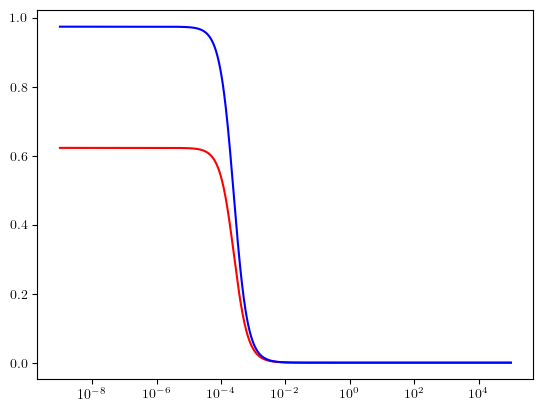

In [613]:
# Plot of k with soln for LCDM compared to 4DEGB
i = 5
Omg_r1 = (1 + (7/8) * (4/11)**(4/3)*(N_eff[7992+i]-3.046))*2.47282e-5/H0[7992+i]**2
Omg_r_LCDM1 = 2.47282e-5/H0[7992+i]**2
cosmo_val = [cosmo[0][7992+i] , cosmo[1][7992+i], cosmo[2] ,cosmo[3][7992+i] , cosmo[4][7992+i]]
cosmo_val_LCDM = [cosmo[0][7992+i] , cosmo[1][7992+i], cosmo[2] ,cosmo[3][7992+i] , 0]
soln = solve_for_growth(a_val, cosmo_val, k_val*(3e5/100)/cosmoCCL["h"])[0].T
soln_LCDM = solve_for_growth(a_val, cosmo_val_LCDM, k_val*(3e5/100)/cosmoCCL["h"])[0].T

plt.plot(k_val, soln[0],"r")
plt.plot(k_val, soln_LCDM[0],"b")
plt.xscale("log")

0.04360848868747412
0.01084014359178331
99.68513578821924
99.99697670001893
99.9999690618133


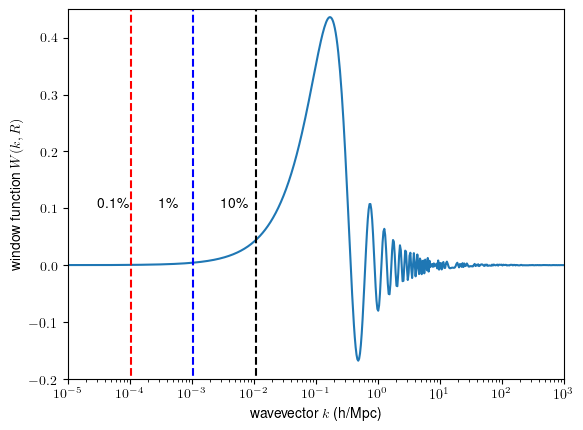

In [614]:
# Checking integral works 
k_val = np.logspace(-9,5,1000) # in Mpc^-1 
cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][0],
                                   Omega_b=cosmo[1][0], 
                                   A_s=A_s[0],
                                   h = H0[0]/100,
                                   n_s=n_s[0],
                                   Omega_k=cosmo[2],
                                   Omega_g=cosmo[3][0],
                                   Neff = 3.046,
                                   m_nu = 0.6000000E-01
                                  )
plt.plot(k_val,sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False))
print(np.max(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"]))*0.1)
plt.text(0.00003, 0.1, "0.1\%")
plt.text(0.0003, 0.1, "1\%")
plt.text(0.003, 0.1, "10\%")
indx_peak = find_nearest(np.max(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"])),sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"]))
indx_10 = find_nearest(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"])[:indx_peak], np.max(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"]))*0.1)
indx_1 = find_nearest(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"])[:indx_peak], np.max(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"]))*0.01)
indx_01 = find_nearest(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"])[:indx_peak], np.max(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"]))*0.001)

plt.plot(k_val[indx_10]*np.ones(2), np.linspace(-0.3,0.5,2), "k--")
plt.plot(k_val[indx_1]*np.ones(2), np.linspace(-0.3,0.5,2), "b--")
plt.plot(k_val[indx_01]*np.ones(2), np.linspace(-0.3,0.5,2), "r--")
plt.xscale("log")
plt.ylim(-0.2,0.45)
plt.xlim(1e-5,1e3)
plt.xlabel(r"wavevector $k$ (h/Mpc)")
plt.ylabel(r"window function $W(k,R)$")
print(k_val[indx_10])
areaTot = sc.integrate.trapz(sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False), x =k_val)
area10 = sc.integrate.trapz(sc.special.spherical_jn(1, k_val[indx_10:]*8/cosmoCCL["h"], derivative=False), x =k_val[indx_10:])
area1 = sc.integrate.trapz(sc.special.spherical_jn(1, k_val[indx_1:]*8/cosmoCCL["h"], derivative=False), x =k_val[indx_1:])
area01 = sc.integrate.trapz(sc.special.spherical_jn(1, k_val[indx_01:]*8/cosmoCCL["h"], derivative=False), x =k_val[indx_01:])
print(area10*1e2/areaTot)
print(area1*1e2/areaTot)
print(area01*1e2/areaTot)

#plt.savefig("Windowfunction.pdf", bbox_inches="tight")

In [622]:
# find sigma_8 predicted from CCL

Omg_r_cut = (1 + (7/8) * (4/11)**(4/3)*(N_eff_cut-3.046))*2.47282e-5*1e4/H0_cut**2
#Omg_r_actual_cut = (1 + (7/8) * (4/11)**(4/3)*(N_eff_cut-3.046/3))*2.47282e-5*1e4/H0_cut**2

Omg_r_LCDM_cut = 2.47282e-5*1e4/H0_cut**2
cosmo_cut = [w_c_cut*1e4/H0_cut**2 , w_b_cut*1e4/H0_cut**2, 0 ,Omg_r_actual_cut , Omg_r_cut - Omg_r_LCDM_cut]
Omg_r_h2_cut = (1 + (7/8) * (4/11)**(4/3)*(N_eff_cut - 3.046))*2.47282e-5



In [ ]:
sigma_8CCL = np.zeros(len(N_eff_cut))
for i in range(len(N_eff_cut)):
    cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo_cut[0][i],
                               Omega_b=cosmo_cut[1][i], 
                               A_s=A_s_cut[i],
                               h = H0_cut[i]/100,
                               n_s=n_s_cut[i],
                               Omega_k=cosmo_cut[2],
                               Omega_g=2.47282e-5*1e4/H0_cut[i]**2,
                               Neff = N_eff_cut[i],
                               m_nu_type = "single",
                               m_nu = 0.6000000E-01
                              )
    sigma_8CCL[i] = ccl.power.sigma8(cosmoCCL)

/nobackup/c2042999/miniconda3/envs/4DEGB_venv/lib/python3.11/site-packages/pyccl/core.py:745: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


KeyboardInterrupt: 

24260
24260


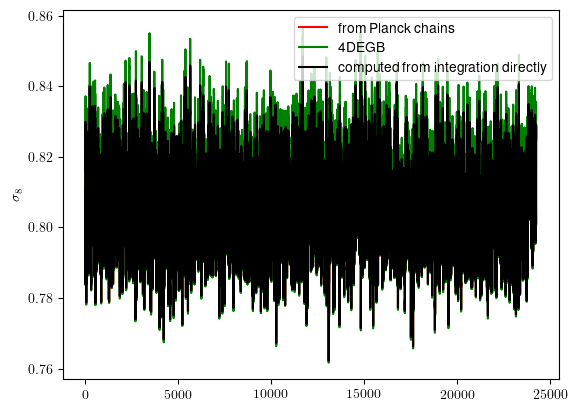

In [624]:
print(len(sigma8))
print(len(sigma8_cut))
#plt.plot(sigma_8CCL, "b", label = "computed using CCL")
plt.plot(sigma8_cut, "r", label = "from Planck chains")
plt.plot(simga8_z_4DEGB, "g", label = "4DEGB")
plt.plot(simga8_z_LCDM, "k", label = "computed from integration directly")
#plt.plot(simga8_z_LCDM/sigma_8CCL)
#plt.ylim(0.5,1.1)
#plt.xlim(0,100)
plt.ylabel(r"$\sigma_8$")
plt.legend()
plt.show()

## Tests

In [ ]:
# TESTS

Omg_r = (1 + (7/8) * (4/11)**(4/3)*(N_eff - 3.046))*2.47282e-5*1e4/H0**2
Omg_r_tot = (1 + (7/8) * (4/11)**(4/3)*(N_eff))*2.47282e-5*1e4/H0**2
Omg_r_h2 = (1 + (7/8) * (4/11)**(4/3)*(N_eff - 3.046))*2.47282e-5
sigma_8CCL = np.zeros(200)
sigma8_Planck = np.zeros(200)
sigma_8CCL2 = np.zeros(200)
sigma_8CCL3 = np.zeros(200)
sigma_8CCL4 = np.zeros(200)
sigma_8CCL5 = np.zeros(200)

powerspecOmgr = np.zeros((200, len(k_val)))
powerspecNeff = np.zeros((200, len(k_val)))
k =0
for i in range(80):
    if N_eff[i] > 3.046:
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i],
                                   Omega_k=cosmo[2],
                                   Omega_g=2.47282e-5*1e4/H0[i]**2,
                                   Neff = N_eff[i],
                                   m_nu = 0.6000000E-01
                                  )
        sigma_8CCL[k] = ccl.power.sigma8(cosmoCCL)
        powerspecNeff[k] = ccl.power.linear_matter_power(cosmoCCL, k_val, 1)
        sigma8_Planck[k] = sigma8[i]
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i],
                                   Omega_k=cosmo[2],
                                   Omega_g=2.47282e-5*1e4/H0[i]**2,
                                   Neff = N_eff[i],
                                   m_nu_type = "single",
                                   m_nu = 0.6000000E-01
                                  )
        sigma_8CCL2[k] = ccl.power.sigma8(cosmoCCL)
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i],
                                   Omega_k=cosmo[2],
                                   T_CMB = (Omg_r_h2[i]/4.545043e-7)**(1/4),
                                   Neff = 3.046,
                                   m_nu = 0.6000000E-01
                                  )
        sigma_8CCL3[k] = ccl.power.sigma8(cosmoCCL)
        powerspecOmgr[k] = ccl.power.linear_matter_power(cosmoCCL, k_val, 1)
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i],
                                   Omega_k=cosmo[2],
                                   Omega_g=cosmo[3][i],
                                   Neff = 3.046,
                                   m_nu = 0
                                  )
        sigma_8CCL4[k] = ccl.power.sigma8(cosmoCCL)
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i],
                                   Omega_k=cosmo[2],
                                   Omega_g=Omg_r_tot[i]
                                   )
        sigma_8CCL5[k] = ccl.power.sigma8(cosmoCCL)

        k+=1


In [ ]:
plt.plot(sigma_8CCL[:19], "b", label = r"CCL - $\delta N_{eff} \neq 0$ and mnu = 0.06")
plt.plot(sigma_8CCL2[:19], "g", label = r"CCL - $\delta N_{eff} \neq 0$ single")
plt.plot(sigma_8CCL3[:19], "purple", label = r"Varying T_CMB")
#plt.plot(sigma_8CCL4[:19], "pink", label = r"CCL - $\delta \Omega_{r0} \neq 0$ and mnu = 0")
#plt.plot(sigma_8CCL5[:19], "y--", label = r"CCL - $\delta \Omega_{r0} \neq 0, N_{eff} =0$")
plt.plot(sigma8_Planck[:19], "r", label = "from Planck chains")
plt.xlim(0,30)
plt.xlabel("count")
plt.ylabel(r"$\sigma_8$")
plt.title(r"$\sigma_8$ predicted with different methods")
plt.legend()
#plt.savefig("different_sigma8_predictions.pdf")


In [ ]:
# TESTS

Omg_r_tot = (1 + (7/8) * (4/11)**(4/3)*(N_eff))*2.47282e-5*1e4/H0**2
Omg_r_h2 = (1 + (7/8) * (4/11)**(4/3)*(N_eff))*2.47282e-5
sigma_8CCL = np.zeros(200)
sigma8_Planck = np.zeros(200)
sigma_8CCL3 = np.zeros(200)
sigma_8CCL2 = np.zeros(200)
a_iter = np.linspace(0.001,1,50)
k_iter = np.logspace(-7,1,400) # in Mpc^-1 

powerspecOmgr = np.zeros((200, len(k_iter)))
powerspecNeff = np.zeros((200, len(k_iter)))
k =0
for i in range(30):
    if N_eff[i] > 3.046:
        
        sigma8_Planck[k] = sigma8[i]
        
        # Using Omega_r method - different cosmo for Power spec and for background
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i]
                                  )
        pk_a = []
        for j in range(len(a_iter)):
            pk_a.append(ccl.power.nonlin_matter_power(cosmo = cosmoCCL, k=k_iter, a=a_iter[j]))
        pk_a = np.array(pk_a)
        pk2d_val = ccl.pk2d.Pk2D(a_arr=a_iter, lk_arr=np.log(k_iter), pk_arr=pk_a, is_logp=False)
        
        sigma_8CCL3[k] = ccl.power.sigma8(cosmoCCL, p_of_k_a = pk2d_val)
        sigma_8CCL[k] = ccl.power.sigma8(cosmoCCL)

        powerspecNeff[k] = ccl.power.nonlin_matter_power(cosmoCCL, k_iter, 1)
        powerspecOmgr[k] = pk2d_val.eval(k_iter, 1, cosmo = cosmoCCL)
        k+=1


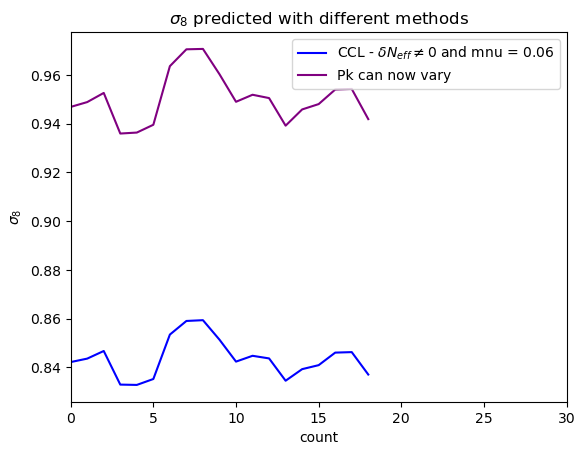

In [20]:
plt.plot(sigma_8CCL[:19], "b", label = r"CCL - $\delta N_{eff} \neq 0$ and mnu = 0.06")
plt.plot(sigma_8CCL3[:19], "purple", label = r"Pk can now vary")

plt.xlim(0,30)
plt.xlabel("count")
plt.ylabel(r"$\sigma_8$")
plt.title(r"$\sigma_8$ predicted with different methods")
plt.legend()
#plt.savefig("different_sigma8_predictions.pdf")


In [ ]:
plt.plot(k_iter, powerspecOmgr[10])
plt.plot(k_iter, powerspecNeff[10], "--")
plt.yscale("log")
plt.xscale("log")

/tmp/ipykernel_436555/864151511.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot((sigma_8CCL[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "b", label = r"CCL - $\delta N_{eff} \neq 0$ and mnu = 0.06")
/tmp/ipykernel_436555/864151511.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot((sigma_8CCL2[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "g", label = r"CCL - $\delta N_{eff} \neq 0$ and mnu = 0")
/tmp/ipykernel_436555/864151511.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot((sigma_8CCL3[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "purple", label = r"CCL - $\delta \Omega_{r0} \neq 0$ and mnu = 0.06")
/tmp/ipykernel_436555/864151511.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot((sigma_8CCL4[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "pink", label = r"CCL - $\delta \Omega_{r0} \neq 0$ and mnu = 0")


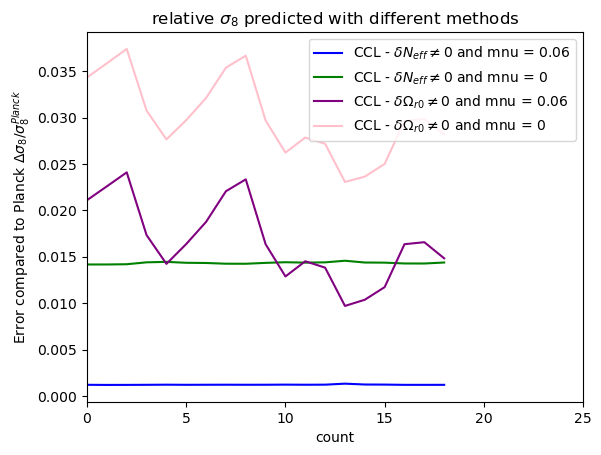

In [24]:
plt.plot((sigma_8CCL[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "b", label = r"CCL - $\delta N_{eff} \neq 0$ and mnu = 0.06")
plt.plot((sigma_8CCL2[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "g", label = r"CCL - $\delta N_{eff} \neq 0$ and mnu = 0")
plt.plot((sigma_8CCL3[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "purple", label = r"CCL - $\delta \Omega_{r0} \neq 0$ and mnu = 0.06")
plt.plot((sigma_8CCL4[:20]-sigma8_Planck[:20])/sigma8_Planck[:20], "pink", label = r"CCL - $\delta \Omega_{r0} \neq 0$ and mnu = 0")
plt.xlim(0,25)
plt.xlabel("count")
plt.ylabel(r"Error compared to Planck $\Delta \sigma_8 /\sigma_8^{Planck}$")
plt.title(r"relative $\sigma_8$ predicted with different methods")

plt.legend()
#plt.savefig("different_relative_sigma8_predictions.pdf")

#plt.plot(sigma_8CCL/sigma8_Planck)

4561
4561


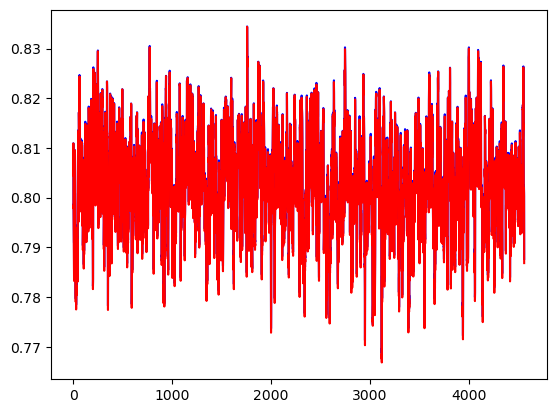

In [73]:
plt.plot(sigma8_cut, "b")
print(len(sigma8_cut))
print(len(simga8_z_4DEGB))
plt.plot(np.sqrt(simga8_z_4DEGB) * sigma8_cut/np.sqrt(simga8_z_LCDM), "r")

## Results

24260


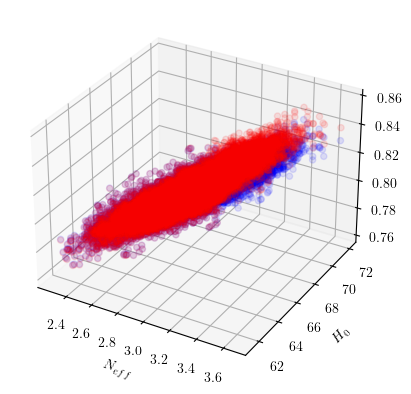

In [625]:
avg_S8 = np.zeros(len(N_eff_cut))
for i in range(len(N_eff_cut)):
    avg_S8[i] = (simga8_z_4DEGB[i])
        
print(len(avg_S8))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(N_eff_cut, H0_cut, sigma8_cut, alpha =0.1, color = "b")
ax.scatter(N_eff_cut, H0_cut, avg_S8, alpha =0.1, color = "r")
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$H_{0}$")
ax.set_zlabel(r"$\sigma_8$")
plt.show()

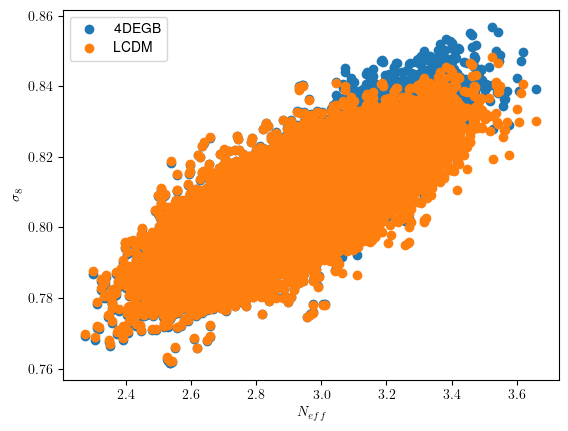

In [626]:
plt.scatter(N_eff_cut, avg_S8, label = "4DEGB")
plt.scatter(N_eff_cut, sigma8_cut, label = "LCDM")
plt.xlabel(r"$N_{eff}$")
plt.ylabel(r"$\sigma_8$")
plt.legend()

In [428]:
print(avg_S8)

[0.80515718 0.81137964 0.79838996 ... 0.83441039 0.83261721 0.83351575]


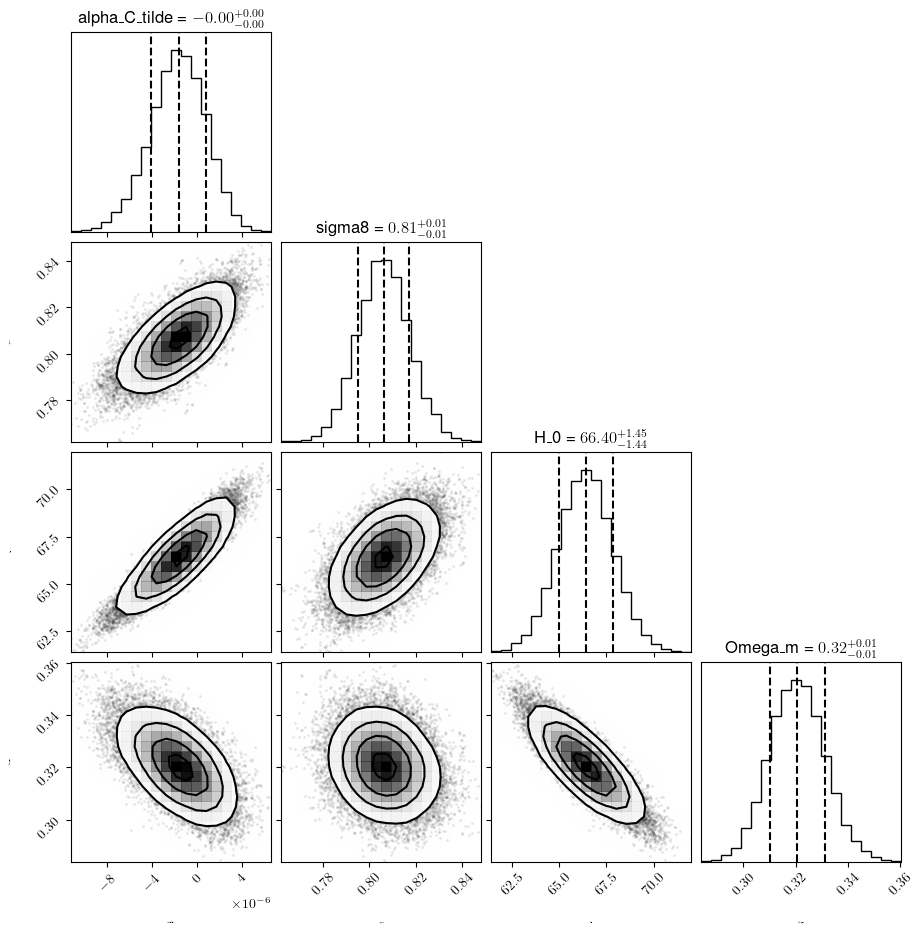

In [100]:
flat_samples = np.array([(Omg_r - Omg_r_LCDM),sigma8,H0,Omega_m_Planck]).T
fig = corner.corner(
    flat_samples, labels=["alpha_C_tilde","sigma8","H_0", "Omega_m"], show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True
);
fig.show()

For uncut Planck chains:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

For cut Planck chains in 4DEGB:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<Figure size 2100x900 with 0 Axes>

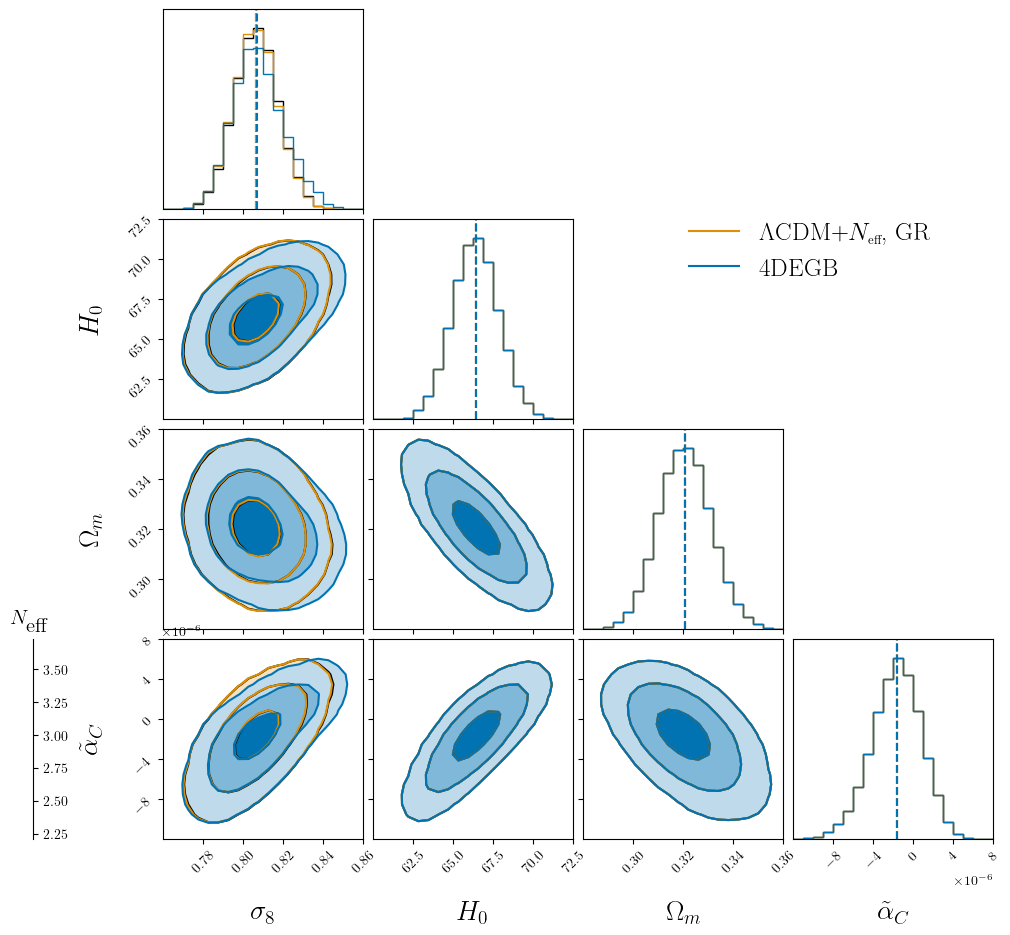

In [802]:
# Processed results
fig = plt.figure(constrained_layout=True,figsize=(7,3),dpi =300)

CORNER_KWARGS_cut = dict(
    show_titles=False, 
    quantiles=[0.50],
    weights = np.ones(len(Omg_r_cut)) * (len(Omg_r) / len(Omg_r_cut)),
    fontsize=8, 
    smooth = True,
    fill_contours=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_datapoints=False,
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=20),
    range=[(0.76,0.86), (60,72.5), (0.28,0.36), (-12e-6, 8e-6)]
)

CORNER_KWARGS = dict(
    show_titles=False, 
    quantiles=[0.50],
    fontsize=8, 
    smooth = True,
    fill_contours=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_datapoints=False,
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=20),
    range=[(0.76,0.86), (60,72.5), (0.28,0.36), (-12e-6, 8e-6)]
)

flat_samples = pd.DataFrame(np.array([(simga8_z_LCDM),H0_cut,Omega_m_Planck_cut,(Omg_r_cut - Omg_r_LCDM_cut)]).T, 
                            columns = [ r"\sigma_8",r"H_0", r"\Omega_m",r"\tilde{\alpha}_C"])
    
fig = corner.corner(
    flat_samples, **CORNER_KWARGS_cut
);

flat_samples = pd.DataFrame(np.array([sigma8,H0,Omega_m_Planck,(Omg_r - Omg_r_LCDM)]).T, 
                            columns = [r"\sigma_8",r"H_0", r"\Omega_m",r"\tilde{\alpha}_C"])

corner.corner(flat_samples,fig=fig,**CORNER_KWARGS, labels=[r"$\sigma_8$",r"$H_0$", r"$\Omega_m$",r"$\tilde{\alpha}_C$"], color = col[1],\
             linewidths=2)


print("For uncut Planck chains:")

for i in range(len(np.array(flat_samples).T)):
    mcmc = np.percentile(np.array(flat_samples)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4e}_{{-{1}}}^{{{2}}}"
    txt = txt.format(mcmc[1], (q[0]), \
                     (q[1]), flat_samples.columns[i])
    display(Math(txt))
    

flat_samples = pd.DataFrame(np.array([avg_S8,H0_cut,Omega_m_Planck_cut,(Omg_r_cut - Omg_r_LCDM_cut)]).T, 
                            columns = [r"\sigma_8",r"H_0", r"\Omega_m",r"\tilde{\alpha}_C"])

corner.corner(flat_samples,fig=fig,**CORNER_KWARGS_cut, labels=[r"$\sigma_8$",r"$H_0$", r"$\Omega_m$",r"$\tilde{\alpha}_C$"], color = col[0],\
             )

#plt.setp(plt.get_xticklabels(), visible=False)
#plt.gca().twiny().set_xlabel("N_eff")


print("For cut Planck chains in 4DEGB:")

for i in range(len(np.array(flat_samples).T)):
    mcmc = np.percentile(np.array(flat_samples)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4e}_{{-{1}}}^{{{2}}}"
    txt = txt.format(mcmc[1], (q[0]), \
                     (q[1]), flat_samples.columns[i])
    display(Math(txt))
    

plt.legend(
        handles=[
            mlines.Line2D([], [], color=[col[1],col[0]][i], label=[r"$\Lambda\textrm{CDM+}N_{\small\textrm{eff}}\textrm{, GR}$",\
                                                                 r"$\textrm{4DEGB}$"][i])
            for i in range(2)
        ],
        fontsize=18, frameon=False,
        bbox_to_anchor=(0.8, 3.2), loc="upper right"
    )


#### Add extra axes for Neff ####
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
#par1 = plt.gca().twiny() #.plot(N_eff,sigma8, color = 'w')
par2 = plt.gca().twinx() #.plot(sigma8,N_eff, color = 'w')

par2.spines["right"].set_position(("axes", -3.8))
#par1.spines["top"].set_position(("axes", 1.2))

make_patch_spines_invisible(par2)
make_patch_spines_invisible(par1)
# Second, show the right spine.
par2.spines["right"].set_visible(True)
#par1.spines["top"].set_visible(True)

par2.set_xlim(-12e-6, 8e-6)

p2, = par2.plot((Omg_r - Omg_r_LCDM), N_eff,"w")
#p1 = par1.hist((Omg_r - Omg_r_LCDM),bins=20)#par1.plot(N_eff,(Omg_r - Omg_r_LCDM),"r")#
#par1.set_xlim(0,4000)
fig.text(-0.055,0.325, r"$N_{\textrm{eff}}$", fontfamily = "Helvetica", size = 15)
p2.remove()

#plt.savefig("Cornerplot_zeroalpha_Planck.pdf", bbox_inches='tight')
fig.show()

<Figure size 2100x900 with 0 Axes>

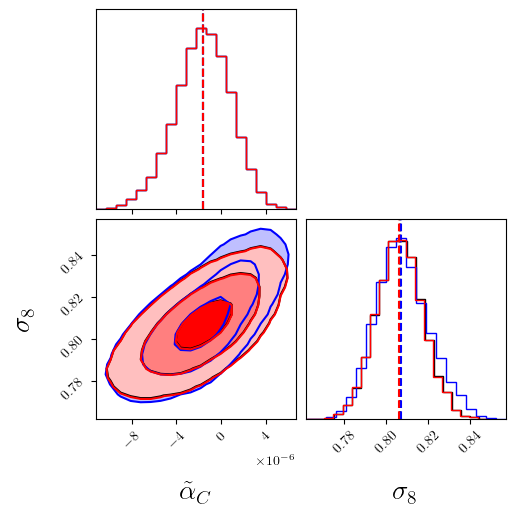

In [629]:
# Processed results
fig = plt.figure(constrained_layout=True,figsize=(7,3),dpi =300)

CORNER_KWARGS_cut = dict(
    show_titles=False, 
    quantiles=[0.50],
    weights = np.ones(len(Omg_r_cut)) * (len(Omg_r) / len(Omg_r_cut)),
    fontsize=8, 
    smooth = True,
    fill_contours=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_datapoints=False,
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=20)
)

CORNER_KWARGS = dict(
    show_titles=False, 
    quantiles=[0.50],
    fontsize=8, 
    smooth = True,
    fill_contours=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_datapoints=False,
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=20)
)

flat_samples = pd.DataFrame(np.array([(Omg_r_cut - Omg_r_LCDM_cut),(simga8_z_LCDM)]).T, 
                            columns = [r"\tilde{\alpha}_C", r"\sigma_8"])
    
fig = corner.corner(
    flat_samples, **CORNER_KWARGS_cut
);

flat_samples = pd.DataFrame(np.array([(Omg_r_cut - Omg_r_LCDM_cut),avg_S8]).T, 
                            columns = [r"\tilde{\alpha}_C",r"\sigma_8"])

corner.corner(flat_samples,fig=fig,**CORNER_KWARGS_cut, labels=[r"$\tilde{\alpha}_C$",r"$\sigma_8$"], color = "b")


flat_samples = pd.DataFrame(np.array([(Omg_r - Omg_r_LCDM),sigma8]).T, 
                            columns = [r"\tilde{\alpha}_C",r"\sigma_8"])

corner.corner(flat_samples,fig=fig,**CORNER_KWARGS, labels=[r"$\tilde{\alpha}_C$",r"$\sigma_8$"], color = "r")






#plt.savefig("Cornerplot_zeroalpha_Planck.pdf")
fig.show()

In [784]:
# Compare to LCDM Planck chains

# Import the datafiles
content1 = pd.read_table('base_plikHM_TTTEEE_lowl_lowE_1.txt', delim_whitespace=True, header=None)
content2 = pd.read_table('base_plikHM_TTTEEE_lowl_lowE_2.txt', delim_whitespace=True, header=None)
content3 = pd.read_table('base_plikHM_TTTEEE_lowl_lowE_3.txt', delim_whitespace=True, header=None)
content4 = pd.read_table('base_plikHM_TTTEEE_lowl_lowE_4.txt', delim_whitespace=True, header=None)

# get data for N_eff, sigma_8 and H_0
# N_eff = array[6+1], H_0 = array[30+1], sigma8 = array[36+1]

# This means the first two are probably not params, given there are 99 in total

H0_base = np.append(np.append(np.append(content1[29],content2[29]),content3[29]),content4[29])
sigma8_base = np.append(np.append(np.append(content1[35],content2[35]),content3[35]),content4[35])
Omega_m_Planck_base = np.append(np.append(np.append(content1[31],content2[31]),content3[31]),content4[31])


del content1, content2,content3,content4



In [785]:
print(len(H0_base))

24497


For cut Planck chains in 4DEGB:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

For base LCDM Planck chains:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

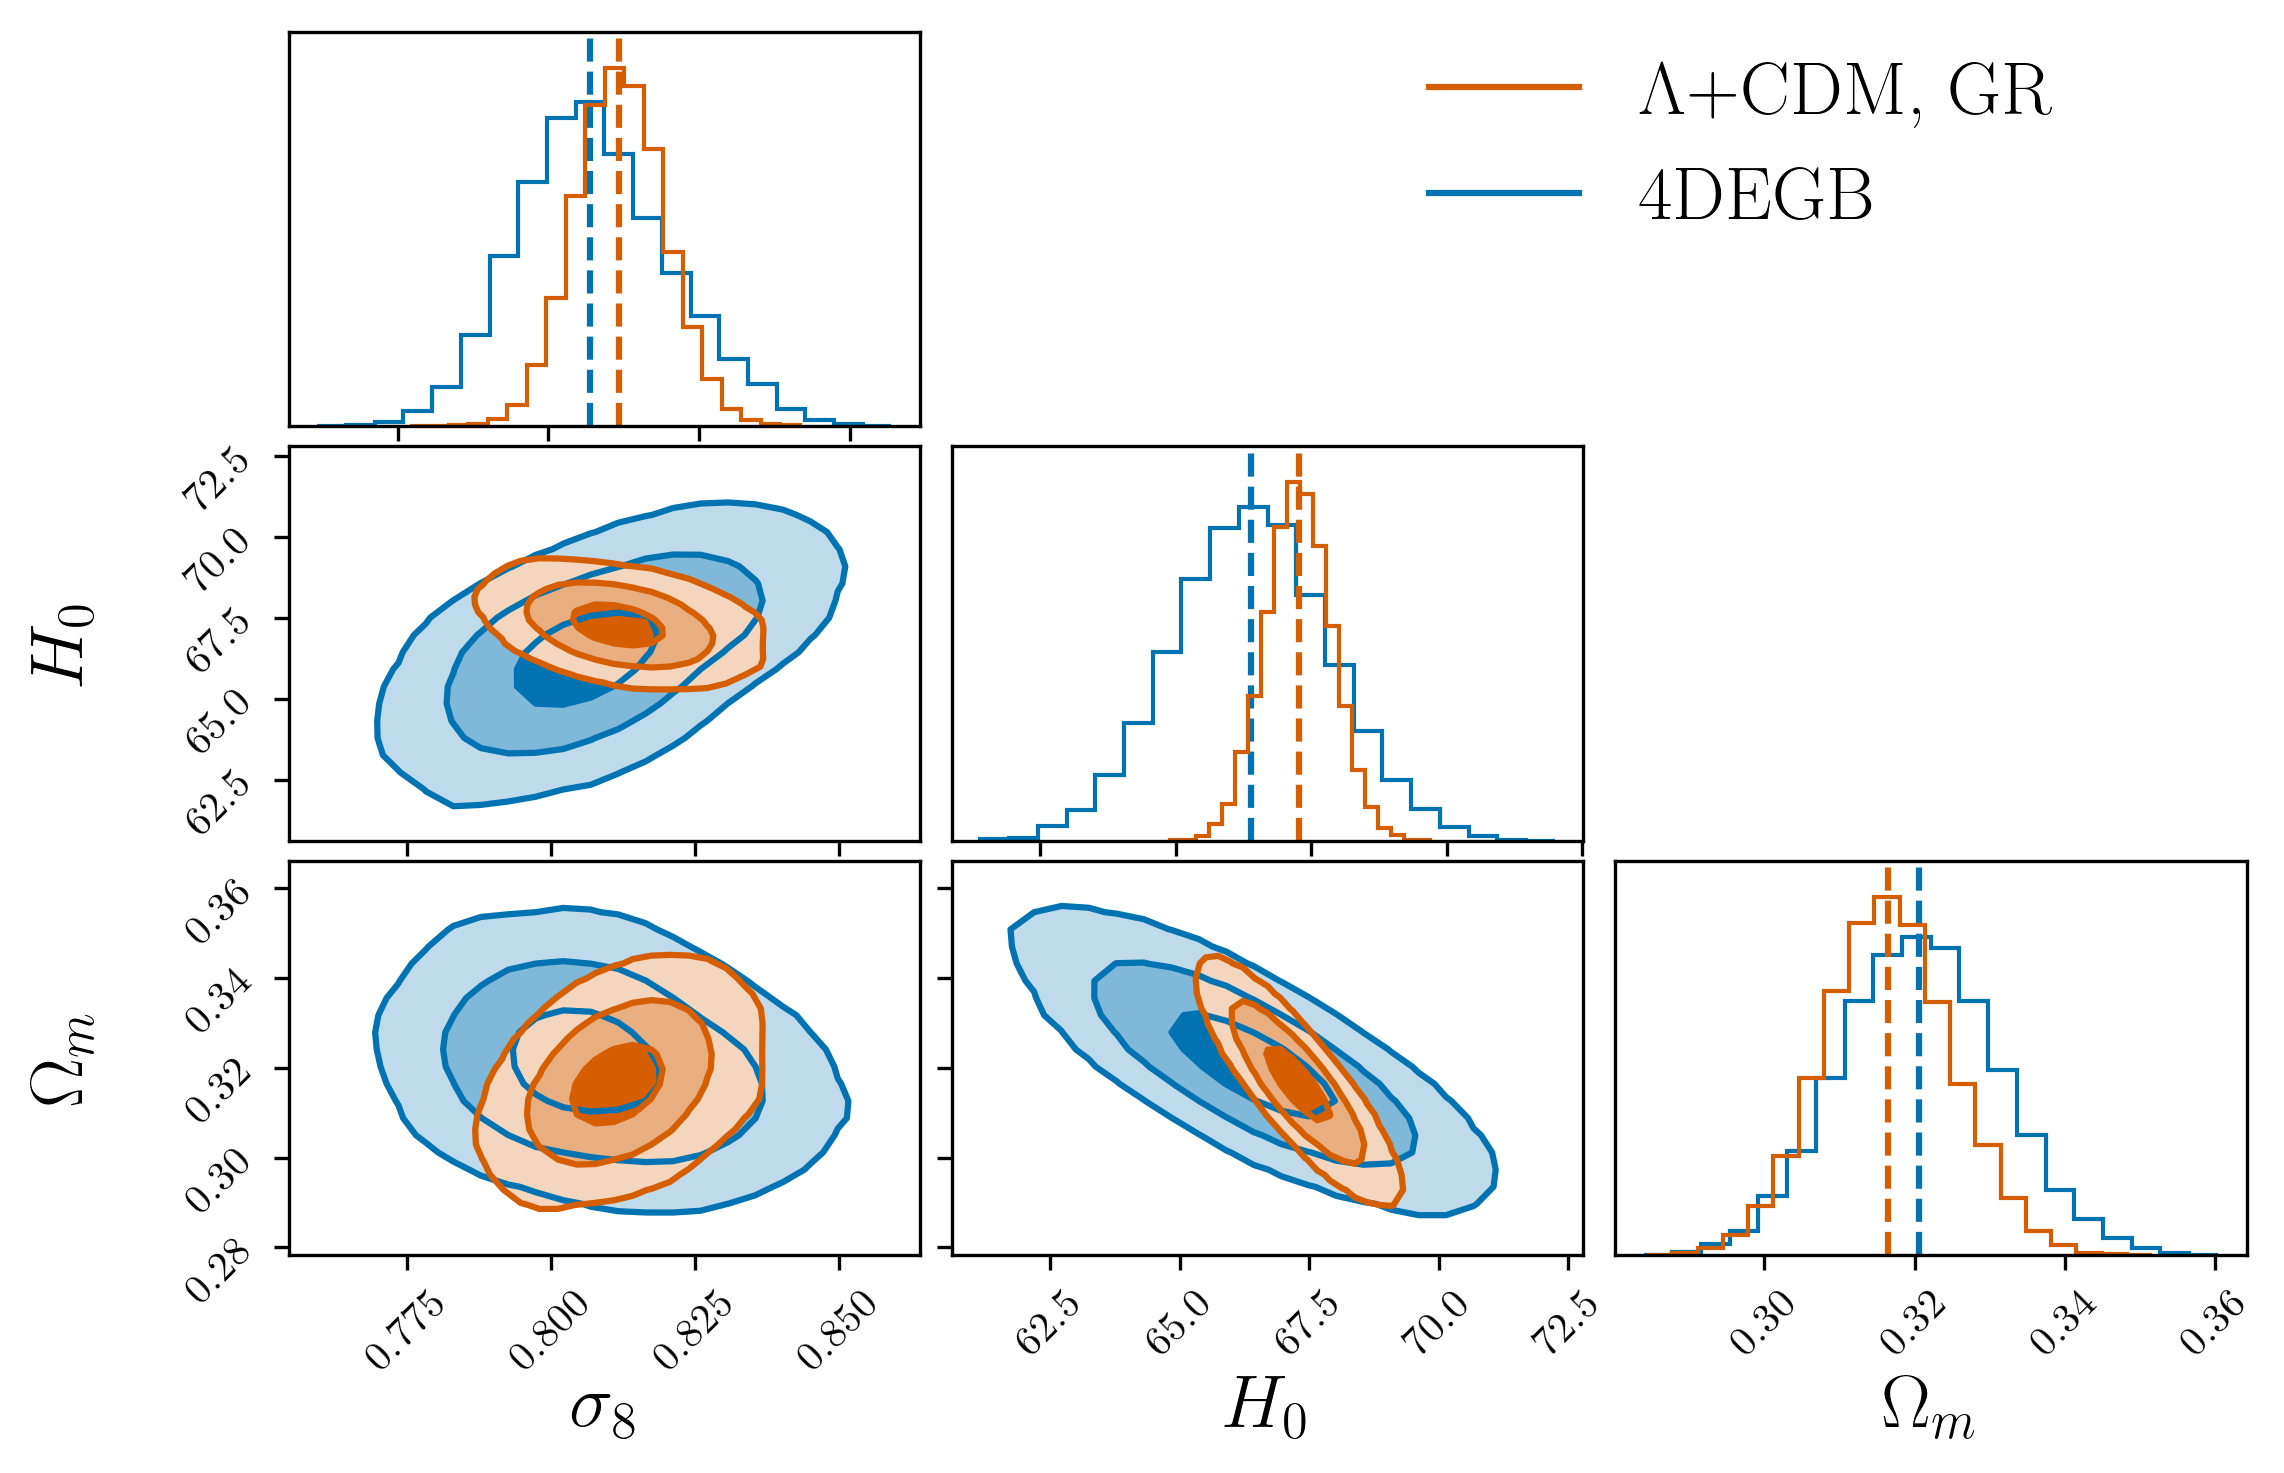

In [792]:
# Processed results
fig = plt.figure(figsize=(8,5),dpi =300)

CORNER_KWARGS_cut = dict(
    show_titles=False, 
    quantiles=[0.50],
    weights = np.ones(len(Omg_r_cut)) * (len(Omg_r) / len(Omg_r_cut)),
    fontsize=8, 
    smooth = True,
    fill_contours=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_datapoints=False,
    label_kwargs=dict(fontsize=18),
    title_kwargs=dict(fontsize=18)
)

CORNER_KWARGS = dict(
    show_titles=False, 
    quantiles=[0.50],
    fontsize=8, 
    smooth = True,
    fill_contours=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_datapoints=False,
    label_kwargs=dict(fontsize=18),
    title_kwargs=dict(fontsize=18)
)

    
flat_samples = pd.DataFrame(np.array([avg_S8,H0_cut,Omega_m_Planck_cut]).T, 
                            columns = [r"\sigma_8",r"H_0", r"\Omega_m"])

corner.corner(flat_samples,fig=fig,**CORNER_KWARGS_cut, labels=[r"$\sigma_8$",r"$H_0$", r"$\Omega_m$"], color = col[0])

print("For cut Planck chains in 4DEGB:")

for i in range(len(np.array(flat_samples).T)):
    mcmc = np.percentile(np.array(flat_samples)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4e}_{{-{1}}}^{{{2}}}"
    txt = txt.format(mcmc[1], (q[0]), \
                     (q[1]), flat_samples.columns[i])
    display(Math(txt))
    
flat_samples = pd.DataFrame(np.array([sigma8_base,H0_base,Omega_m_Planck_base]).T, 
                            columns = [r"\sigma_8",r"H_0", r"\Omega_m"])

corner.corner(flat_samples,fig=fig,**CORNER_KWARGS, labels=[r"$\sigma_8$",r"$H_0$", r"$\Omega_m$"], color = col[3])

print("For base LCDM Planck chains:")

for i in range(len(np.array(flat_samples).T)):
    mcmc = np.percentile(np.array(flat_samples)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4e}_{{-{1}}}^{{{2}}}"
    txt = txt.format(mcmc[1], (q[0]), \
                     (q[1]), flat_samples.columns[i])
    display(Math(txt))

plt.legend(
        handles=[
            mlines.Line2D([], [], color=[col[3],col[0]][i], label=[r"$\Lambda\textrm{+CDM, GR}$",\
                                                                 r"$\textrm{4DEGB}$"][i])
            for i in range(2)
        ],
        fontsize=18, frameon=False,
        bbox_to_anchor=(0.8, 3.2), loc="upper right"
    )


#fig.suptitle(r'$\textrm{(Preliminary)}$',x=0.22,y=1,size=18)
#plt.savefig("Cornerplot_zeroalpha_Planck_base.pdf")

fig.show()

In [ ]:
flat_samples = pd.DataFrame(np.array([(Omg_r - Omg_r_LCDM),sigma8,H0,Omega_m_Planck]).T, 
                            columns = [r"$\alpha_C$","sigma8","H_0", "Omega_m"])


In [143]:
"""
import seaborn as sns
CORNER_KWARGS_cut = dict(
    kind ="kde", diag_kind="kde", corner=True
)

flat_samples = pd.DataFrame(np.array([(Omg_r_cut - Omg_r_LCDM_cut),sigma8_cut,H0_cut,Omega_m_Planck_cut]).T, 
                            columns = ["alpha_C_tilde","sigma8","H_0", "Omega_m"])


sns.pairplot(flat_samples, **CORNER_KWARGS_cut)"""

'\nimport seaborn as sns\nCORNER_KWARGS_cut = dict(\n    kind ="kde", diag_kind="kde", corner=True\n)\n\nflat_samples = pd.DataFrame(np.array([(Omg_r_cut - Omg_r_LCDM_cut),sigma8_cut,H0_cut,Omega_m_Planck_cut]).T, \n                            columns = ["alpha_C_tilde","sigma8","H_0", "Omega_m"])\n\n\nsns.pairplot(flat_samples, **CORNER_KWARGS_cut)'

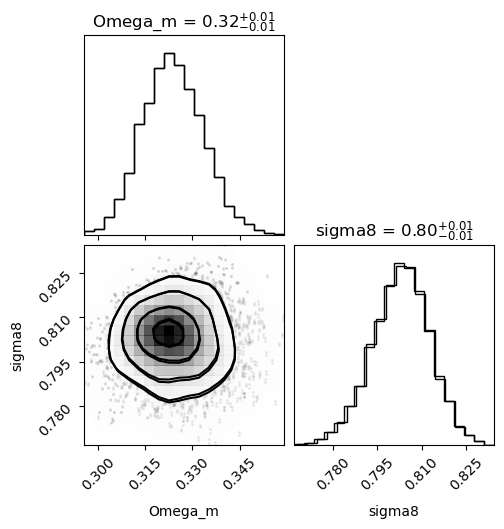

In [20]:
flat_samples = np.array([Omega_m_Planck_cut,sigma8_cut]).T
fig = corner.corner(
    flat_samples, labels=["Omega_m","sigma8"], show_titles=True,  fontsize=8, smooth = True
);

flat_samples = np.array([Omega_m_Planck_cut,avg_S8]).T
corner.corner(flat_samples,fig=fig,  fontsize=8, smooth = True)
plt.show()

In [225]:
# Import the datafiles for KiDS - probe of late-time growth of structure
content_KiDS = pd.read_table('/home/c2042999/Downloads/KiDS1000_vdB22_cosmic_shear_data_release/multinest/Fid_output_multinest_C.txt', delim_whitespace=True, header=None)

# get data for N_eff, sigma_8 and H_0
sigma_8_KiDS = content_KiDS[13][234:]
sigma_8_KiDS = [float(x) for x in sigma_8_KiDS[:-3]]
Omega_m_KiDS = content_KiDS[15][234:]
Omega_m_KiDS = [float(x) for x in Omega_m_KiDS[:-3]]

print(len(Omega_m_KiDS))
del content_KiDS

14743


/tmp/ipykernel_25727/2665281345.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sigma_8_KiDS = [float(x) for x in sigma_8_KiDS[:-3]]
/tmp/ipykernel_25727/2665281345.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Omega_m_KiDS = [float(x) for x in Omega_m_KiDS[:-3]]


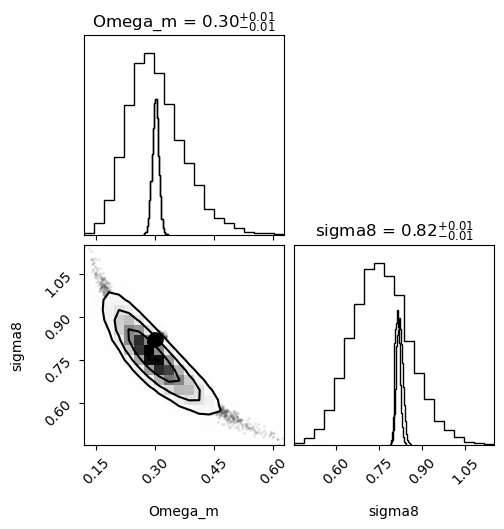

In [227]:
flat_samples = np.array([Omega_m_Planck_cut,sigma8_cut]).T
fig = corner.corner(
    flat_samples, labels=["Omega_m","sigma8"], show_titles=True,  fontsize=8, smooth = True
);

flat_samples = np.array([Omega_m_Planck_cut,avg_S8]).T
corner.corner(flat_samples,fig=fig,  fontsize=8, smooth = True)

flat_samples = np.array([Omega_m_KiDS[-9391:-1],sigma_8_KiDS[-9391:-1]]).T
corner.corner(flat_samples,fig=fig, smooth = True)
plt.show()

# Extra stuff

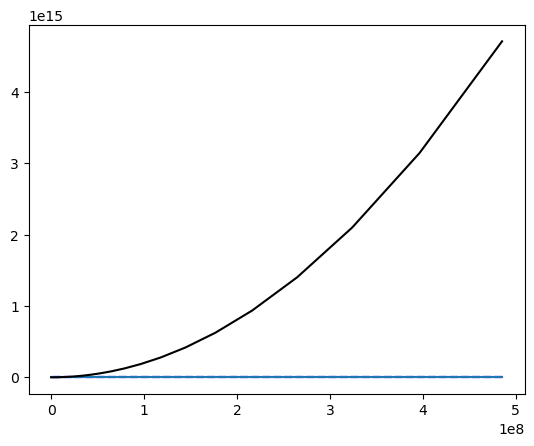

In [14]:
"""Gamma Parametrization - note no k dependence"""
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-4]
soln1 = solve_for_growth(a_val, cosmo, [0.001*(3e5/100),0.001*(3e5/100)])
plt.plot(z_val,np.log(soln1[1][1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo)**2),"b--")
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]
soln1 = solve_for_growth(a_val, cosmo, [0.001*(3e5/100),0.001*(3e5/100)])
plt.plot(z_val,np.log(soln1[1][1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo)**2),"b--")
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-6]
soln1 = solve_for_growth(a_val, cosmo, [0.001*(3e5/100),0.001*(3e5/100)])
plt.plot(z_val,np.log(soln1[1][1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo)**2),"b--")

plt.plot(z_val,np.log(solution_growth_LCDM[1][-1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo_LCDM_array)**2))
plt.plot(z_val,0.02*z_val**2 + 0.55,"k")
#plt.plot(z_val,np.log(solution_growth_LCDM[1][-1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3))
#plt.plot(z_val,ccl.growth_rate(cosmoLCDM,a_val))
#plt.plot(z_val, ((cosmo[0]+cosmo[1])*(1+z_val)**3 \
#                 *a_val**4/ Easquared(a_val,cosmo)**2)**(0.55))

#plt.ylim(0.5,12)

Text(0, 0.5, 'growth factor')

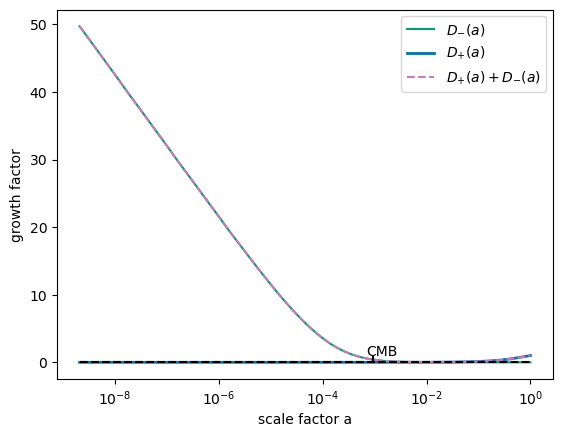

In [15]:
# TRY SOMETHING WITH THE DECAYING MODE INCLUDED

D = solve_for_growth(a_val, cosmo_LCDM_array, [1,1])[0]
def bc_var(ya, yb):
    return np.array([ya[0]-1, yb[0]])

def solve_for_growth_decay(a, cosmo, k):
    
    # x range over which to solve fun
    x = np.logspace(-99,0,100)
    # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
    y_init = np.zeros((2, x.size))
    y_init[0] = x
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for i in range(len(k)):
        soln = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo, k[i]), bc_var, x, y_init).sol(a)
        D_val[i] = soln[0]
        a3EDdot = soln[1]
        f_val[i] = a3EDdot/(D_val[i]*Easquared(a,cosmo))
    return D_val, f_val

D_decay = solve_for_growth_decay(a_val, cosmo_LCDM_array, [1,1])[0]
plt.plot(a_val,1e3*D_decay[0], color = col[2], label = r"$D_{-}(a)$")
plt.plot(a_val,D[0], label = r"$D_{+}(a)$", color = col[0], linewidth=2)
plt.plot(a_val,D[0]+1e3*D_decay[0], "--",color = col[4],label = r"$D_{+}(a) + D_{-}(a)$")
plt.plot(np.ones(100)/1101,np.linspace(0,1,100), "k--")
plt.plot(a_val, np.zeros(len(a_val)), "k--")
plt.text(0.0007, 1.0, "CMB")

plt.xscale("log")
plt.legend()
plt.xlabel("scale factor a")
plt.ylabel(r"growth factor")